# Relevant Information
+ This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).
+ The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.
+ This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns). 

# Bank client data:
1. age (numeric)
2. job: 12 type of job (categorical: admin.,blue-collar,entrepreneur,housemaid,management,retired,self-.employed,services,student,technician,unemployed,unknown(housemaid)
3. marital: marital status (4 categorical: divorced (divorced means divorced or widowed),married,single,unknown(single))
4. education ( 8 categorical: basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown(university.degree)
5. default (nợ): has credit in default? (3 categorical: no,yes,unknown(no))
6. housing: has housing loan? (categorical: no,yes,unknown(yes/no)
7. loan: has personal loan? (categorical: no,yes,unknown(yes/no)

# Related with the last contact of the current campaign:
8. contact: contact communication type (categorical: cellular (di động),telephone) 
9. month: last contact month of year (categorical: jan, feb, mar, ..., nov, dec)
10. day_of_week: last contact day of the week (categorical: mon,tue,wed,thu,fri)
11. duration: last contact duration, in seconds (numeric). 
+ Important note:  this attribute highly affects the output target (e.g., if duration=0 then y=no). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# Other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)(drop)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: failure,nonexistent,success)


# Social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)     
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

# Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: yes,no)

+ Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [1]:
import pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,warnings,xgboost,scipy.stats as stats
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,OneHotEncoder,LabelEncoder
from sklearn.feature_selection import SelectFromModel,SelectKBest,VarianceThreshold,RFECV,mutual_info_classif,f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,auc,plot_confusion_matrix
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('bank-additional-full.csv',header=None)
line = []
for i in range(len(df.index)):
    kq = df.iloc[i,0].split(';')
    for i in kq:
        line.append(i.replace('"',''))
df = pd.DataFrame(np.array(line).reshape(len(df.index),21))
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
df[['age','duration','campaign','pdays','previous']] = df[['age','duration','campaign','pdays','previous']].astype('int')
df[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']] = df[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].astype('float')
df = df.drop(index=df[df['duration'] == 0].index).reset_index(drop=True)
df = df.drop(columns='default',axis=1)
df['pdays'] = df['pdays'].replace(999,0)

# FUNCTION

In [3]:
def Label_encoding_target(target):
    label_encoder = LabelEncoder()
    target = label_encoder.fit_transform(pd.DataFrame(target))
    return target

In [4]:
def Split(df):
    X = df.drop(columns = ['y']).reset_index(drop = True)
    y = df['y'].reset_index(drop = True)
    return X,y

In [5]:
def Data_Mining(df):
    numerical = [feature for feature in df.columns if df[feature].dtype != 'O']
    discrete = [feature for feature in numerical if df[feature].nunique()<25]
    continuous = [feature for feature in numerical if feature not in discrete]
    categorical = [feature for feature in df.columns if df[feature].dtype=='O']
    return numerical,discrete,continuous,categorical

In [6]:
def Feature_NAN(df):
    numerical,discrete,continuous,categorical = Data_Mining(df)
    na_numerical = [feature for feature in numerical if df[feature].isnull().sum()>0]
    na_discrete = [feature for feature in discrete if df[feature].isnull().sum()>0]
    na_continuous = [feature for feature in continuous if df[feature].isnull().sum()>0]
    na_categorical = [feature for feature in categorical if df[feature].isnull().sum()>0]
    return na_numerical,na_discrete,na_continuous,na_categorical

In [7]:
def plot_corr(df,plot_name):
    data = df.corr().iloc[1:,:-1]
    mask = np.triu(np.ones_like(df.corr(),dtype=bool))[1:,:-1]
    cmap = sns.diverging_palette(0,230,90,60,as_cmap=True)
    fig,ax = plt.subplots(figsize=(16,8))
    sns.heatmap(data=data,cmap=cmap,mask=mask,annot=True,annot_kws={'fontsize':13},fmt='.2f',vmin=-1,vmax=1,
                linecolor='white',linewidths=.5)
    ax.set_yticklabels([i.upper() for i in data.index],rotation=0)
    ax.set_xticklabels([i.upper() for i in data.columns],rotation=0)
    ax.set_title(plot_name,loc='right',fontsize=24)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.tight_layout()

In [8]:
def Correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [9]:
def Distribution(df):
    normal_feature = [feature for feature in df.columns if np.abs(np.round(df[feature].skew(),2)) < 0.5]
    skew_feature = [feature for feature in df.columns if np.abs(np.round(df[feature].skew(),2)) >= 0.5]
    return normal_feature,skew_feature

In [10]:
def QQ_plot(df,features):
    for feature in features:
        fig,axs = plt.subplots(1,3,figsize=(20,6))
        plt.rcParams['font.family']='Arial'
        plt.rcParams['font.size']=13
        sns.set_style('dark')
        sns.distplot(df[feature], label="skew: " + str(np.round(df[feature].skew(),2)),ax = axs[0])
        axs[0].legend()
        sns.boxplot(df[feature],ax=axs[2])
        axs[2].set_title('Box Plot')
        stats.probplot(df[feature],dist='norm',plot=axs[1])
        axs[0].set_title('Distribution')
        fig.tight_layout()

# TRAIN, VALID, TEST SPLIT

In [11]:
df['y'] = Label_encoding_target(df['y'])
Train,Valid,Test = np.split(df.sample(frac=1), [int(0.6*len(df)),int(0.8*len(df))])

In [12]:
X_train,y_train = Split(Train)
X_valid,y_valid = Split(Valid)
X_test,y_test = Split(Test)

# CORRELATION
+ Drop high correlation features: cons.price.idx, euribor3m, nr.employed.

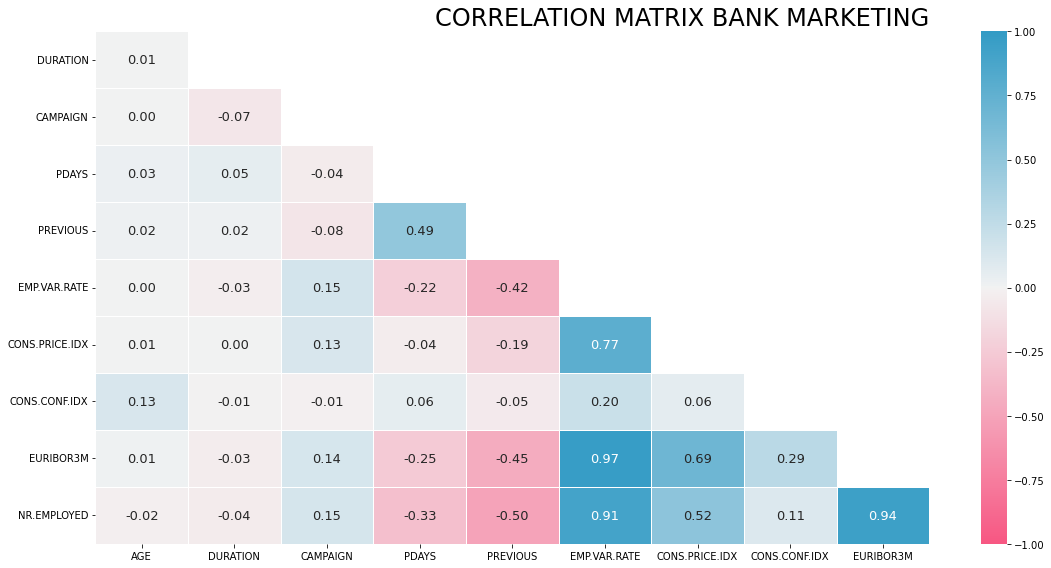

In [13]:
plot_corr(X_train,'CORRELATION MATRIX BANK MARKETING')

In [14]:
corr_features = Correlation(X_train,threshold = 0.7)
X_train = X_train.drop(columns = corr_features,axis=1)
X_valid = X_valid.drop(columns = corr_features,axis=1)
X_test = X_test.drop(columns = corr_features,axis=1)

# EDA
+ Drop 'default' columns
+ 7 features numerical: 3 features discrete, 4 features continuous
+ 9 features categorical
+ No missing values
+ Imbalanced target train (89%(0) - 11%(1))

In [15]:
numerical,discrete,continuous,categorical = Data_Mining(X_train)
na_numerical,na_discrete,na_continuous,na_categorical = Feature_NAN(X_train)

In [16]:
len(numerical)

7

In [17]:
len(continuous)

4

In [18]:
len(categorical)

9

In [19]:
len(na_numerical)

0

In [20]:
len(na_categorical)

0

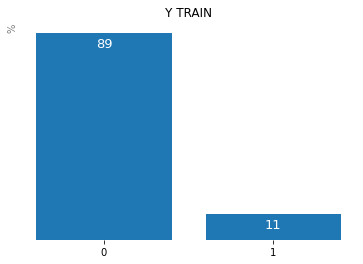

In [21]:
dict_y_train = np.round(y_train.value_counts(normalize=True)*100,0).to_dict()
fig,ax = plt.subplots()
ax.set(title='Y TRAIN')
bar1 = ax.bar(dict_y_train.keys(),dict_y_train.values())
ax.bar_label(bar1,color='white',fontsize=13,padding=-17)
ax.set_ylabel('%',color='gray',loc='top')
ax.set_yticks([])
ax.set_xticks([0,1])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

+ Discrete variables (2)

In [22]:
df_train = pd.concat([X_train,y_train],axis=1)

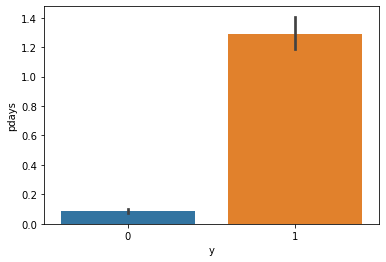

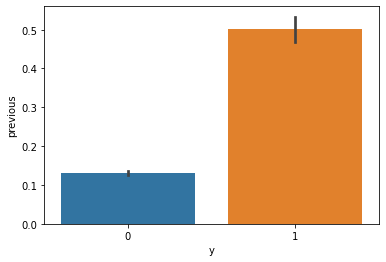

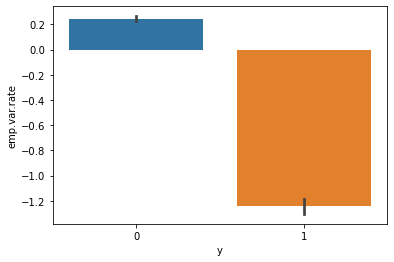

In [23]:
for name in discrete:
    sns.barplot(data=df_train, x=df_train['y'], y=name)
    plt.show();

+ Continuous variables (4): cons.conf.idx (normal distribution) & age,duration,campaign (skewness distribution)

In [24]:
normal_feature, skew_feature = Distribution(X_train[continuous])

In [25]:
normal_feature

['cons.conf.idx']

In [26]:
skew_feature

['age', 'duration', 'campaign']

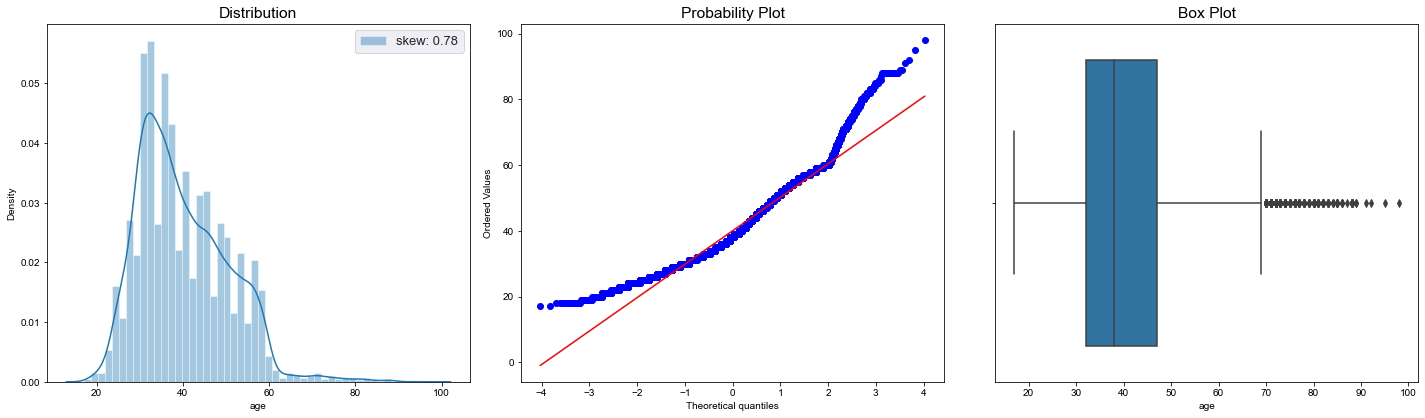

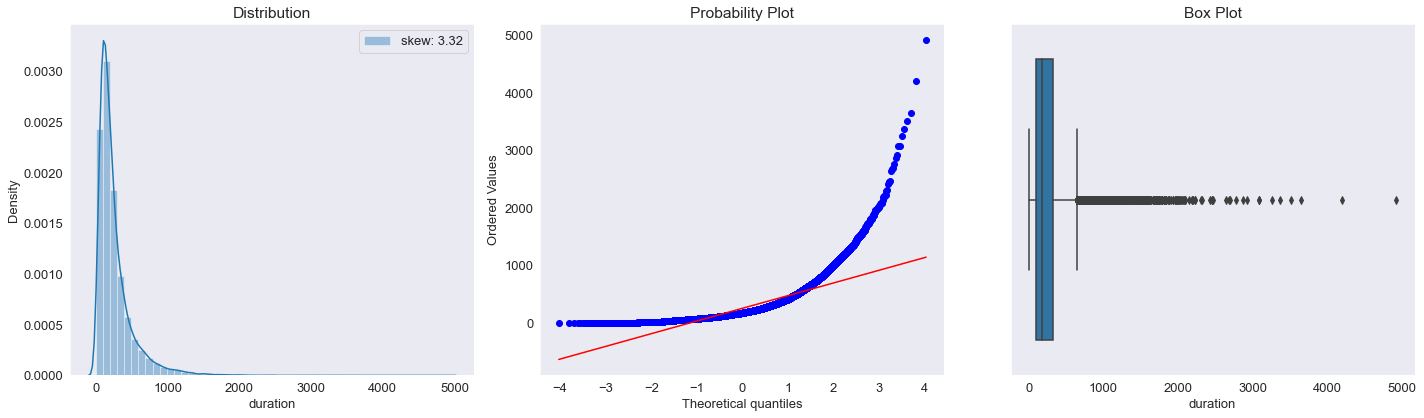

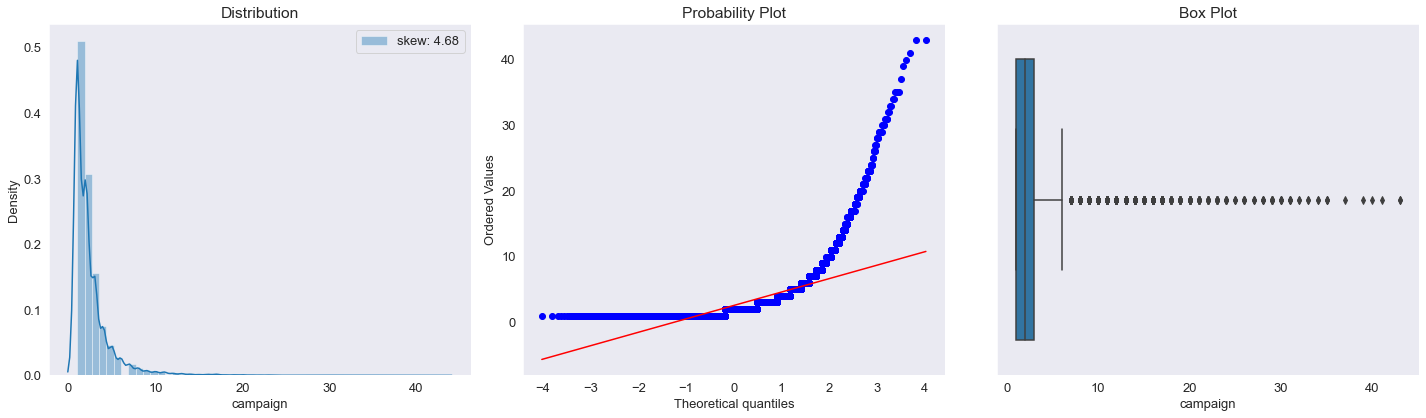

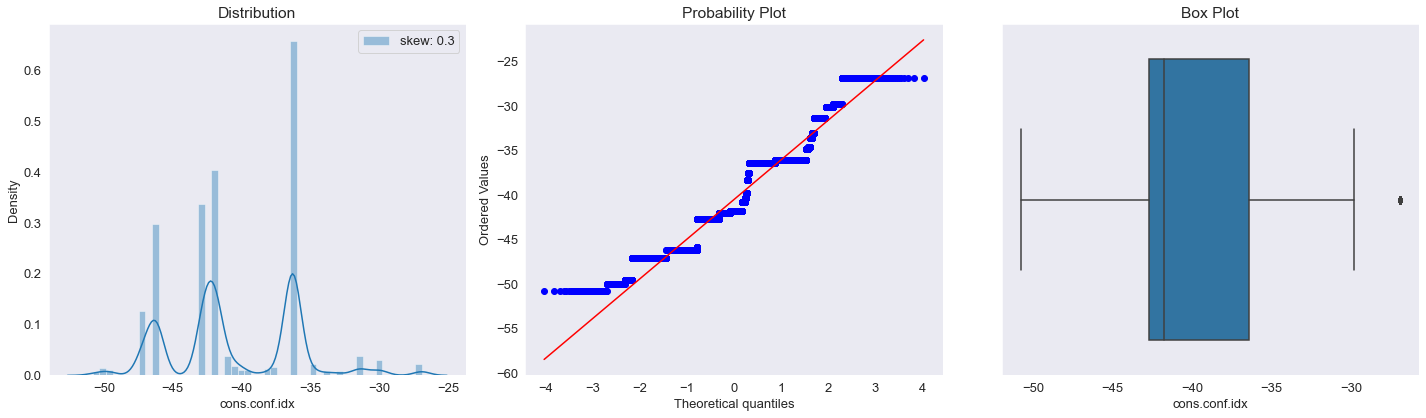

In [27]:
QQ_plot(X_train,continuous);

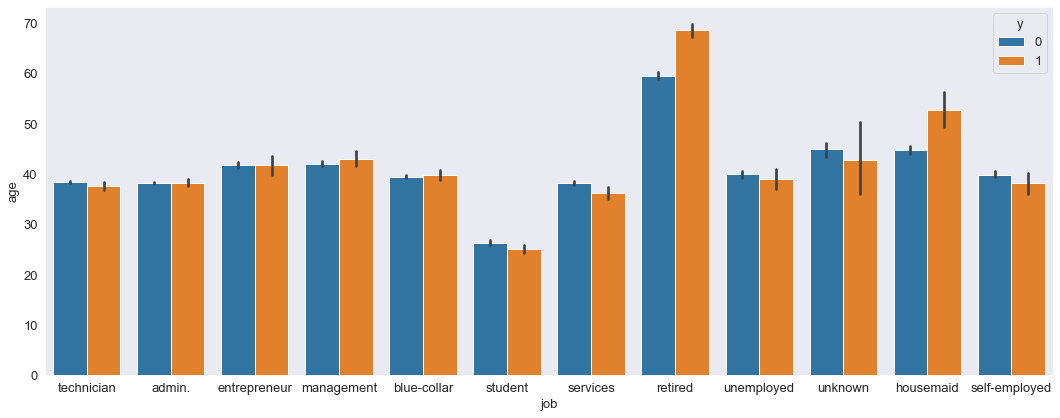

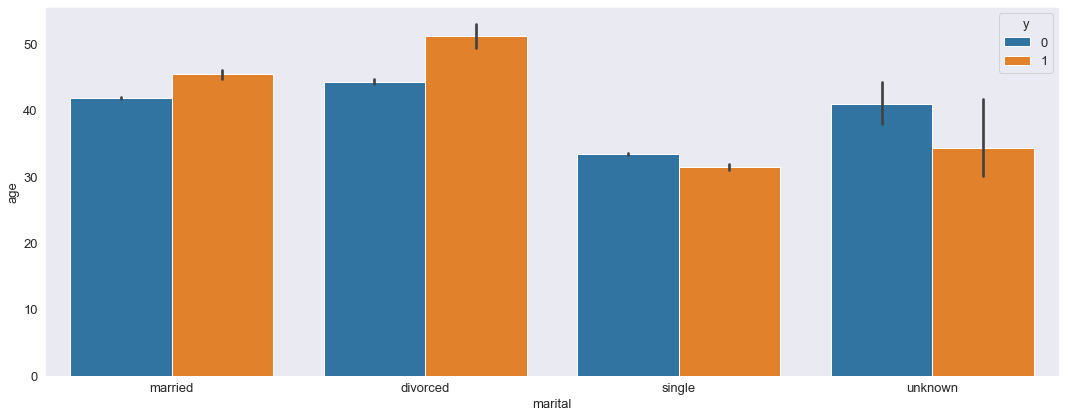

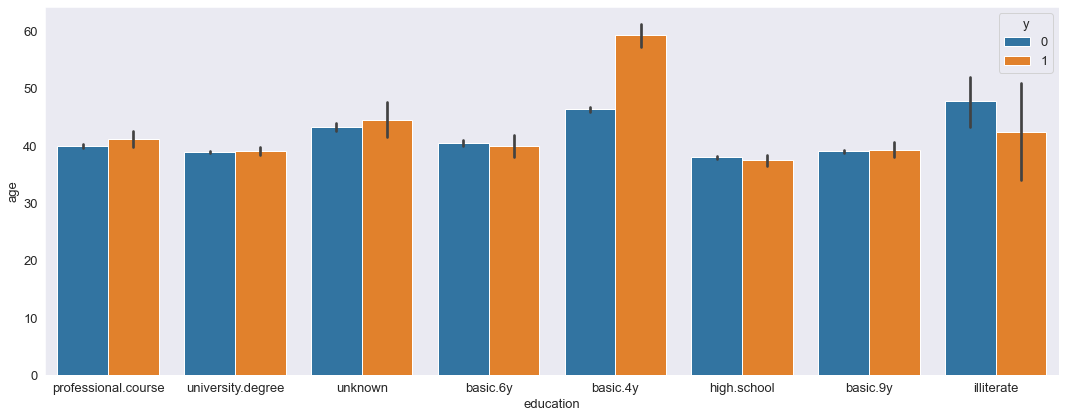

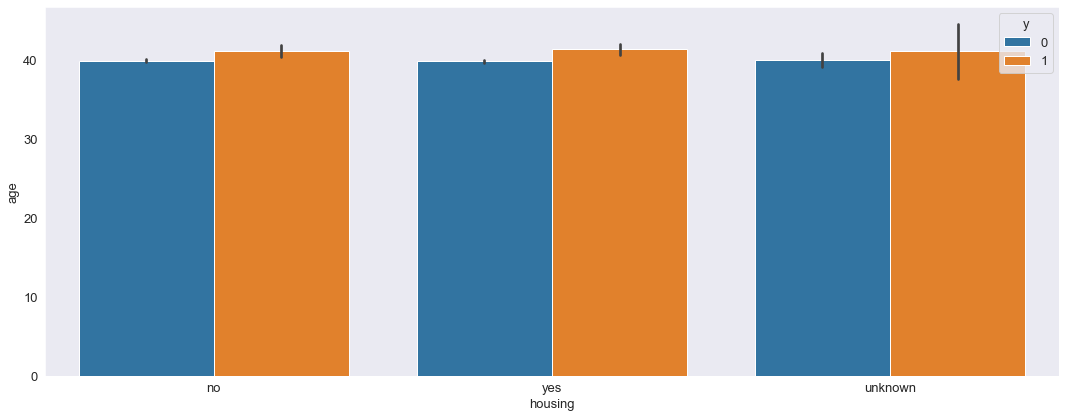

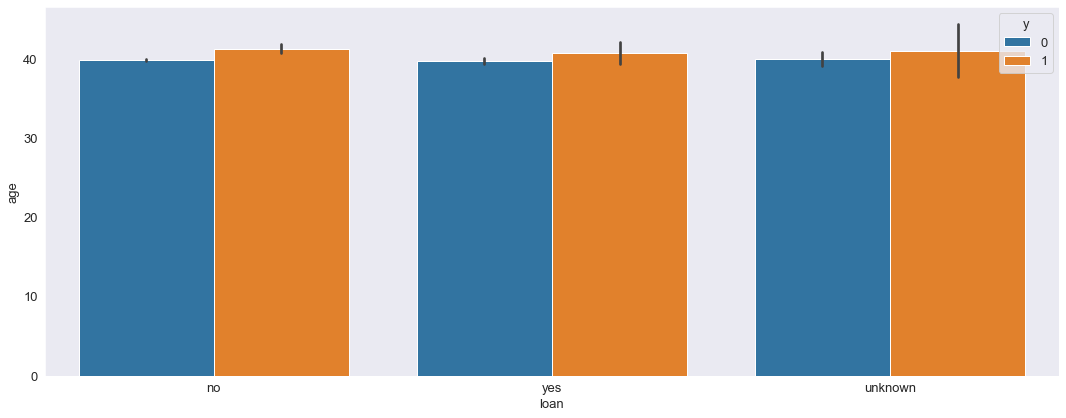

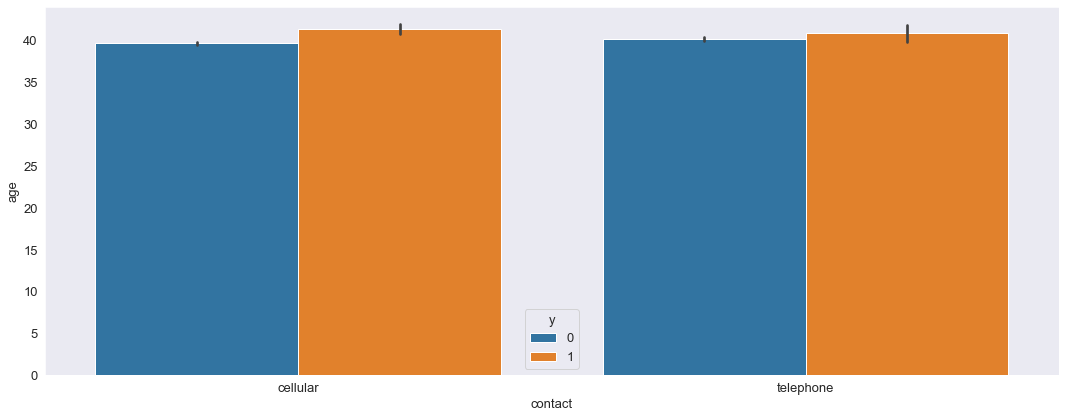

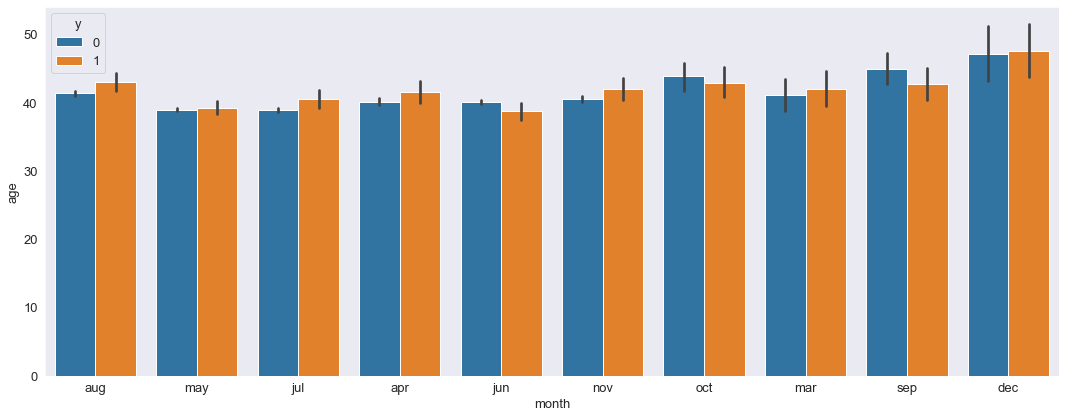

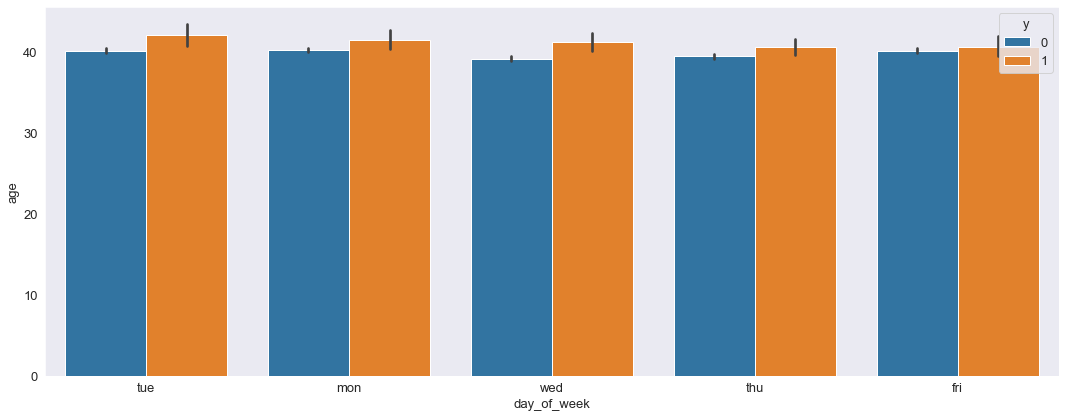

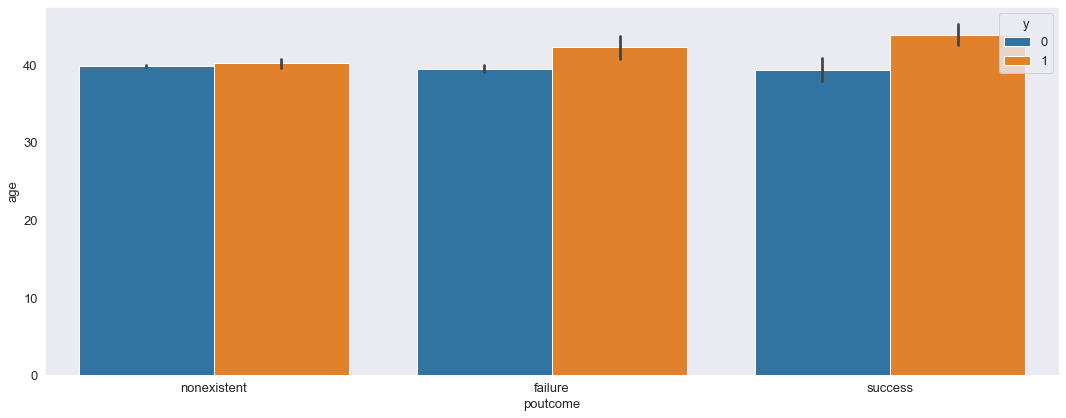

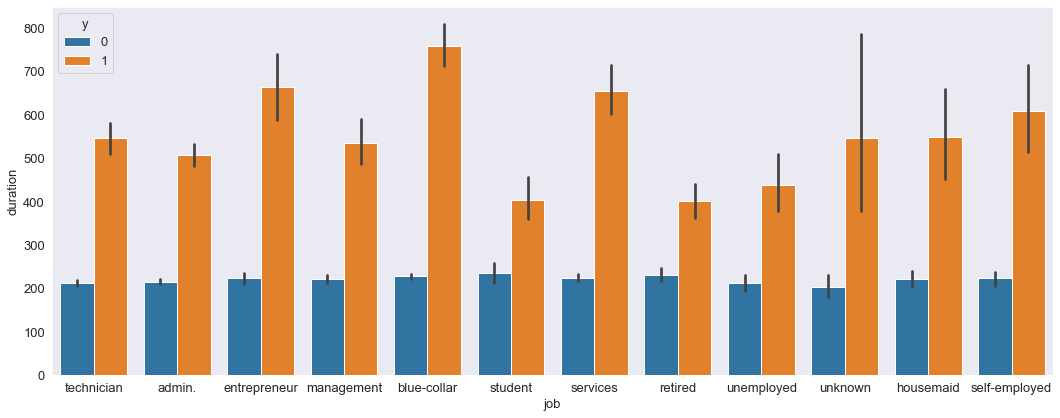

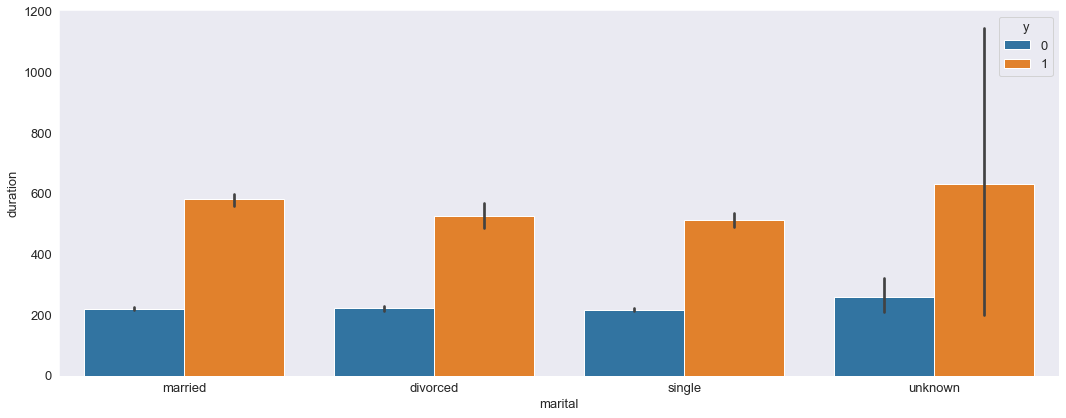

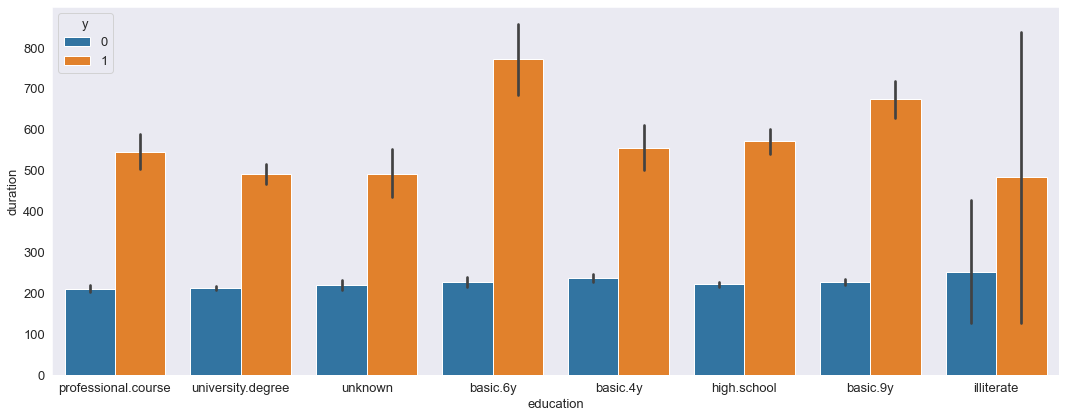

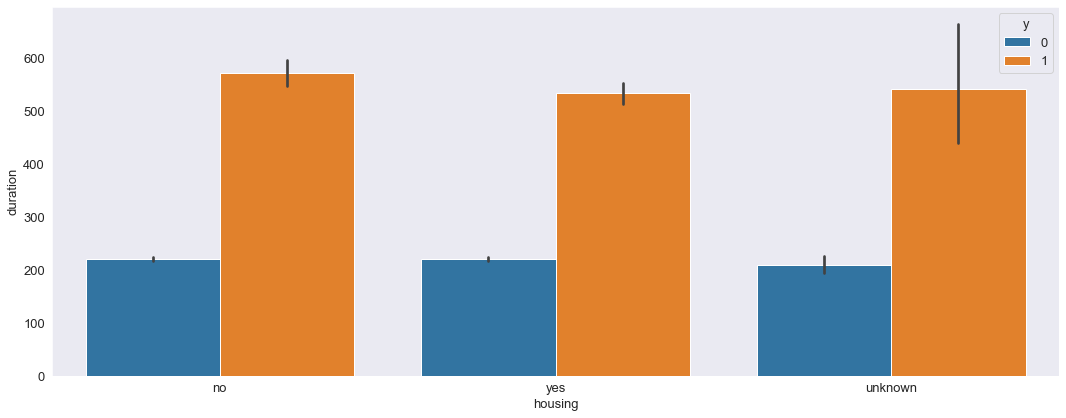

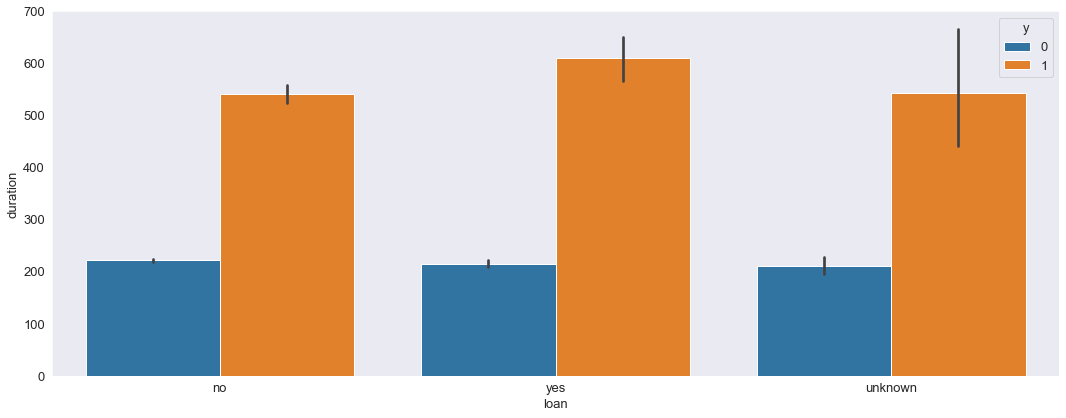

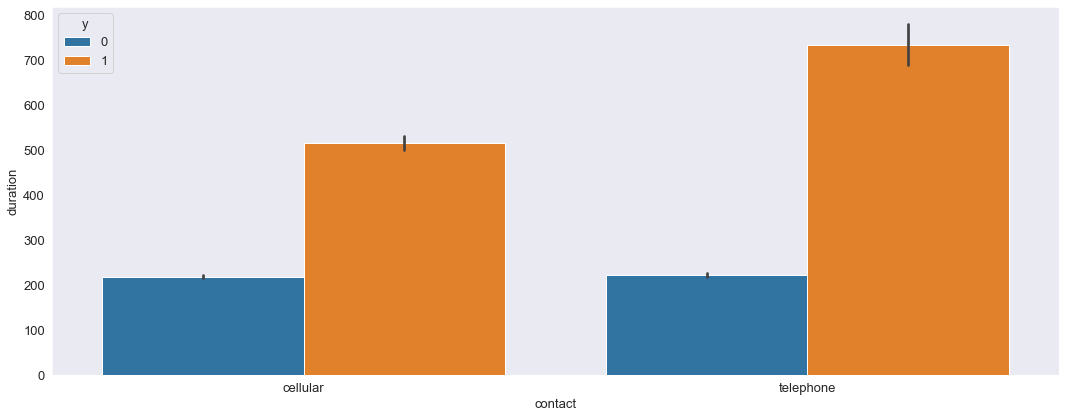

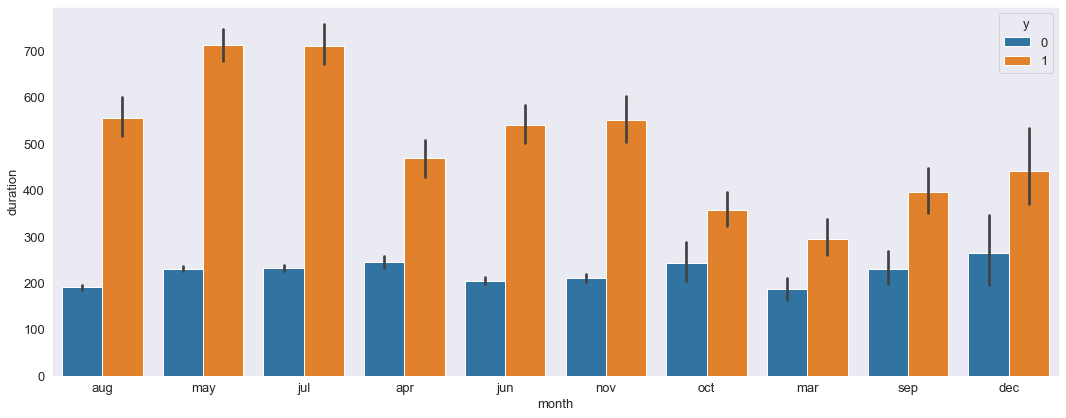

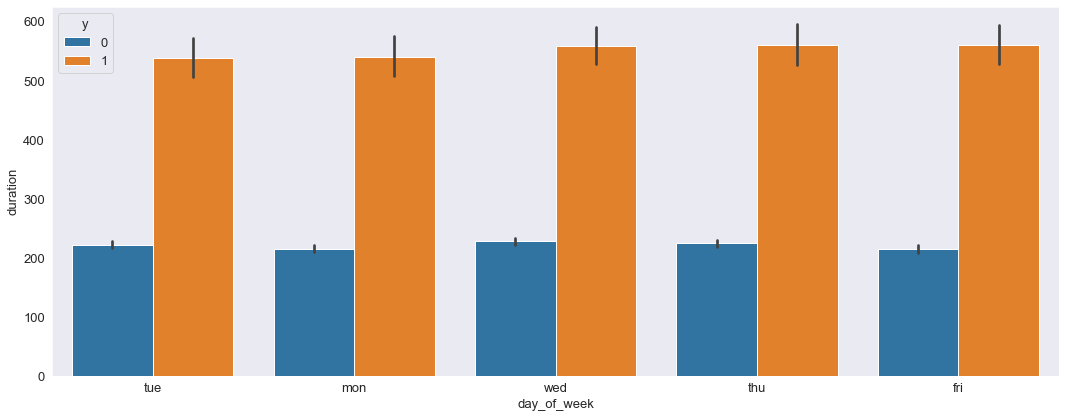

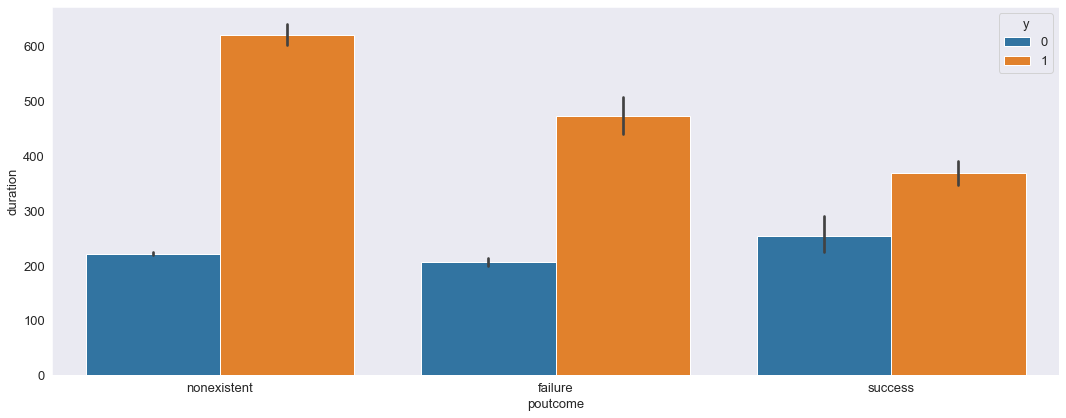

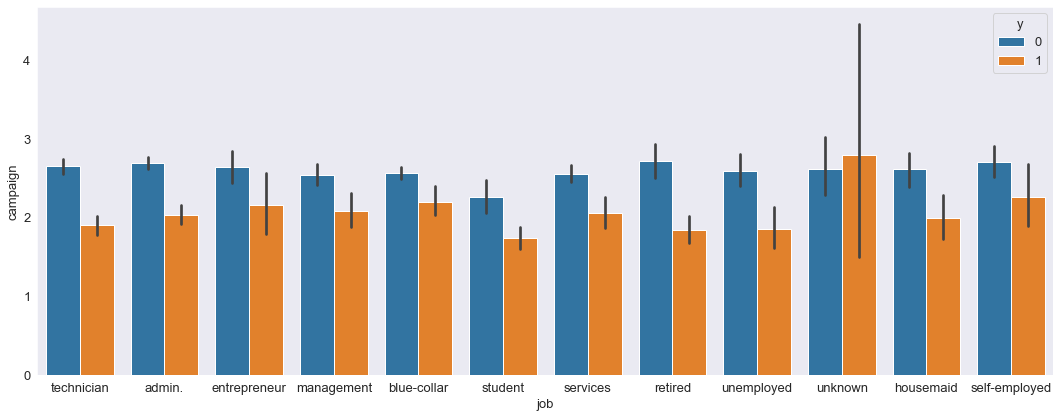

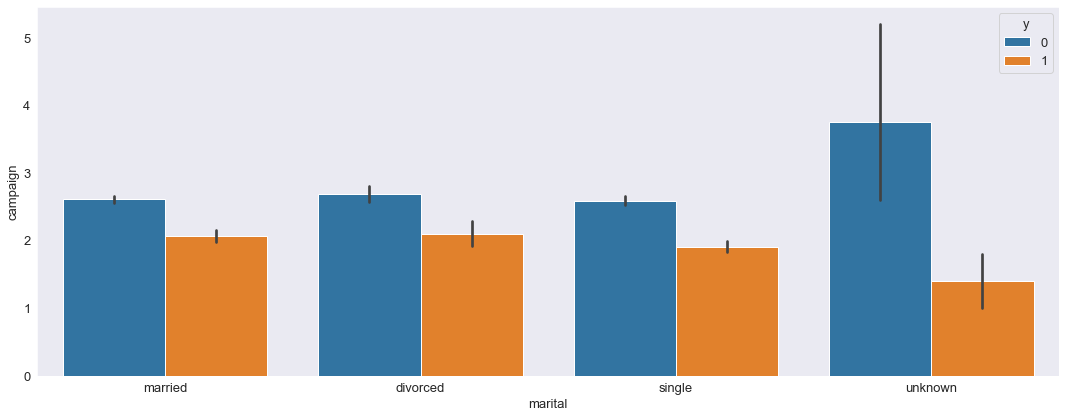

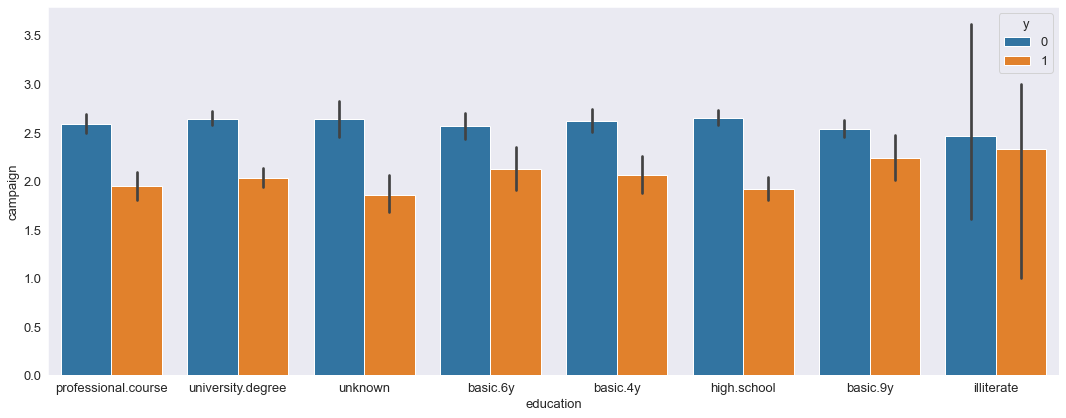

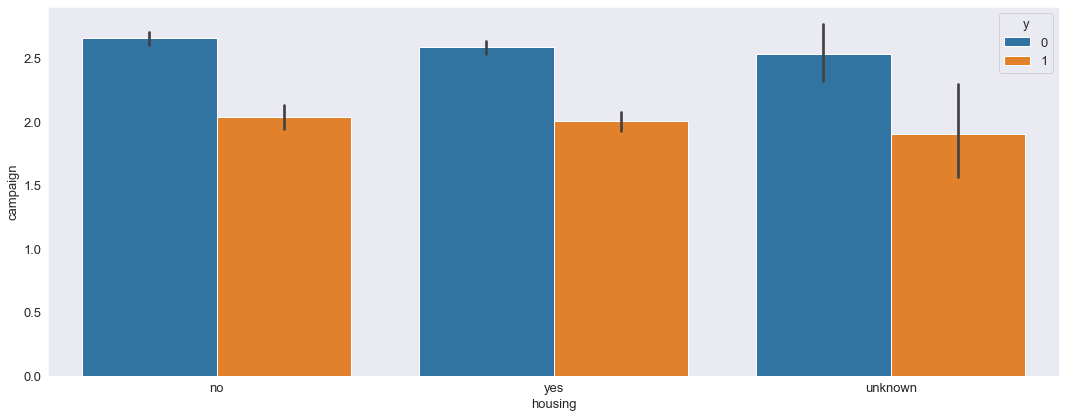

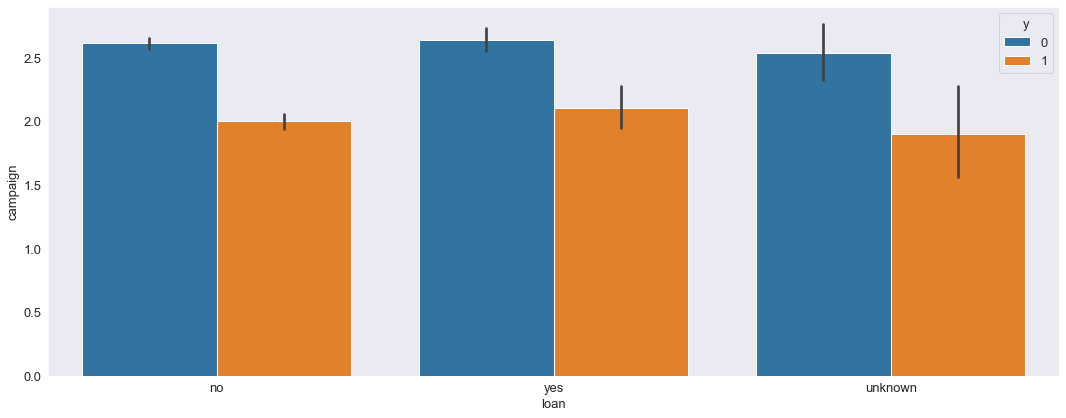

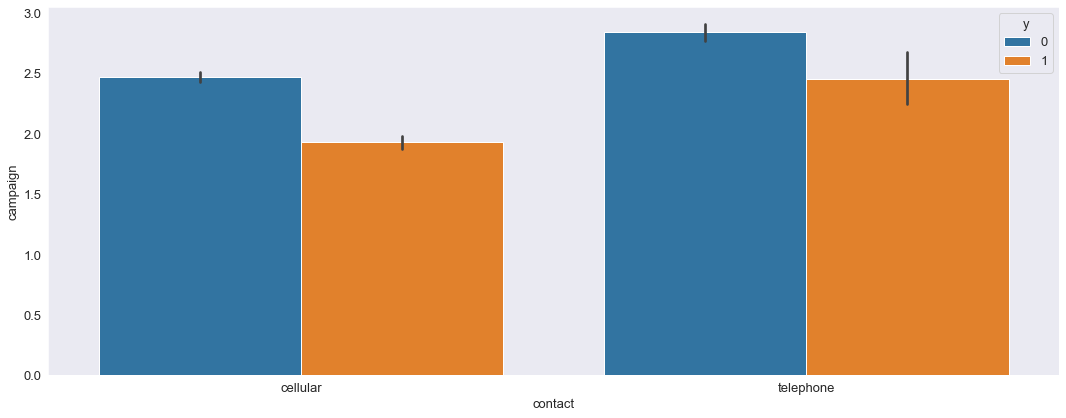

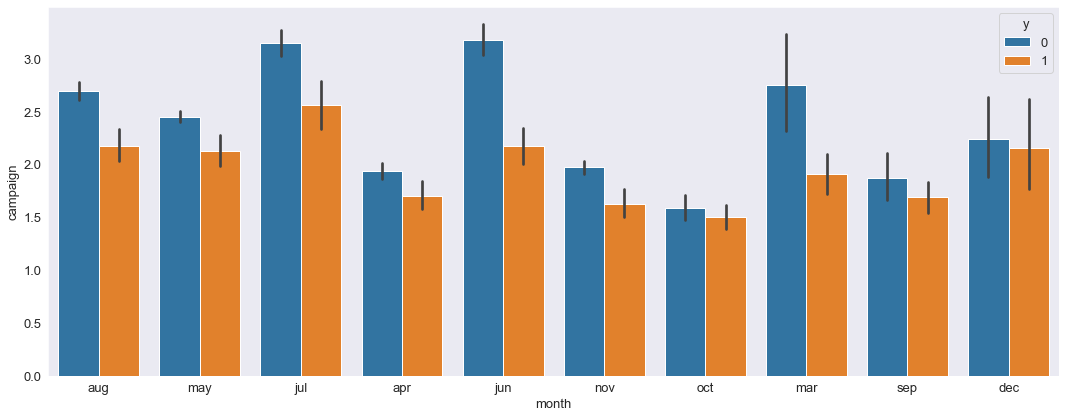

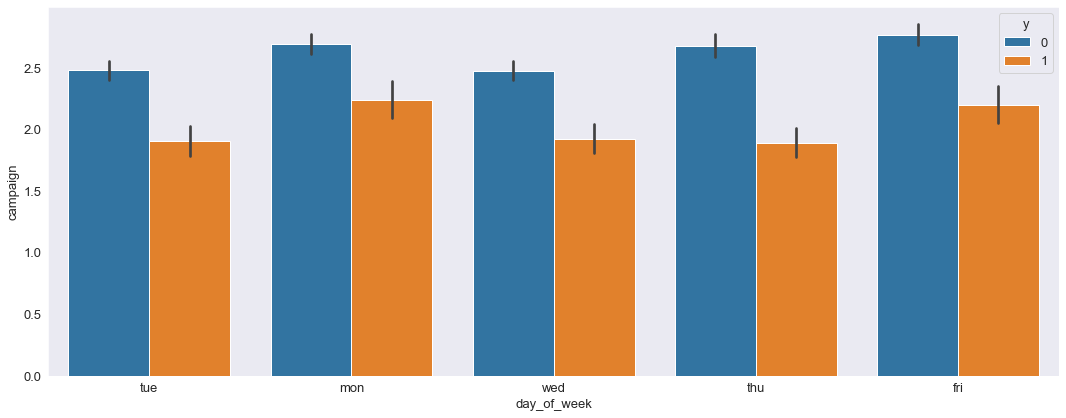

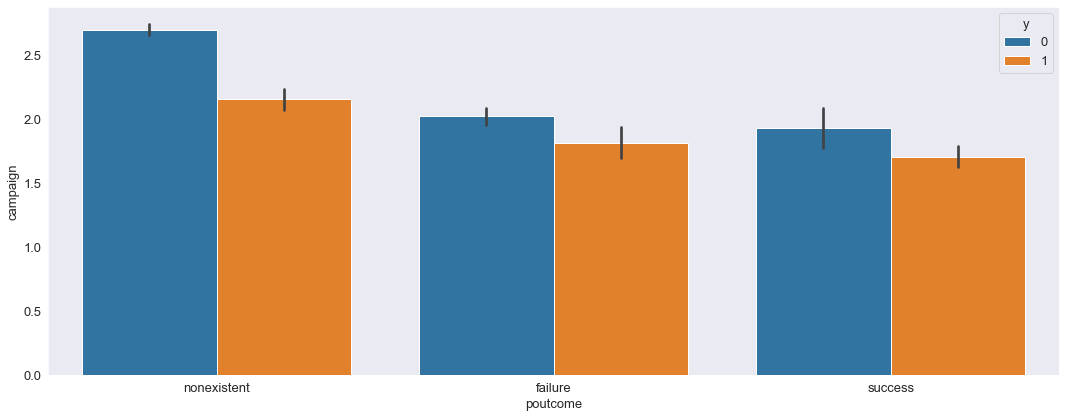

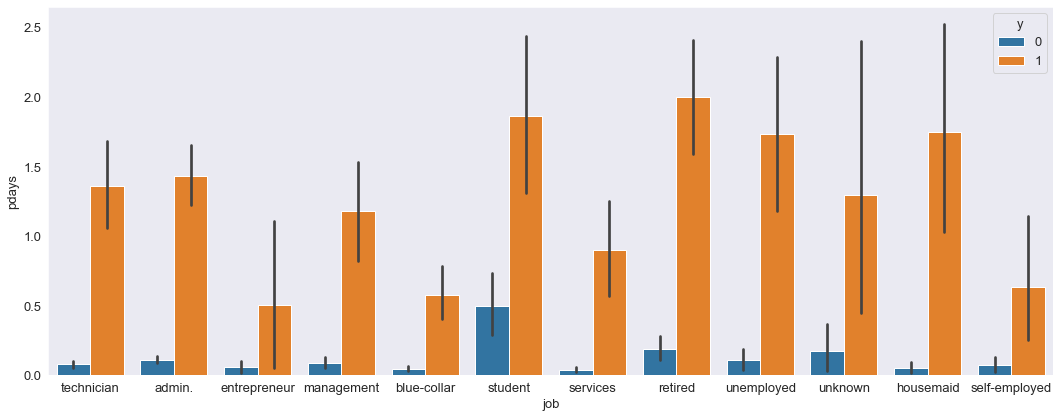

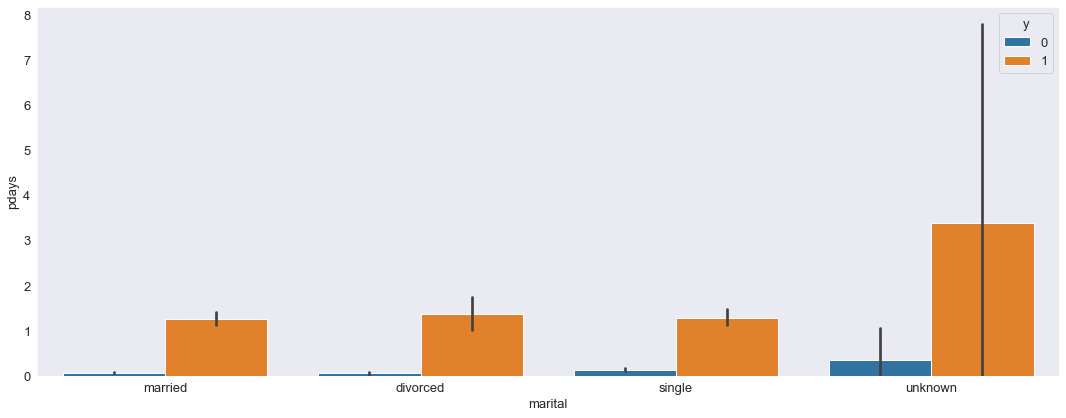

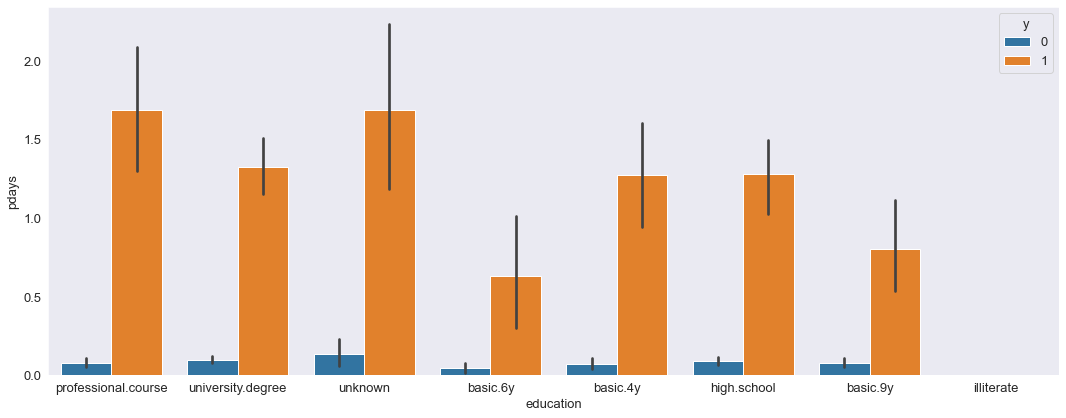

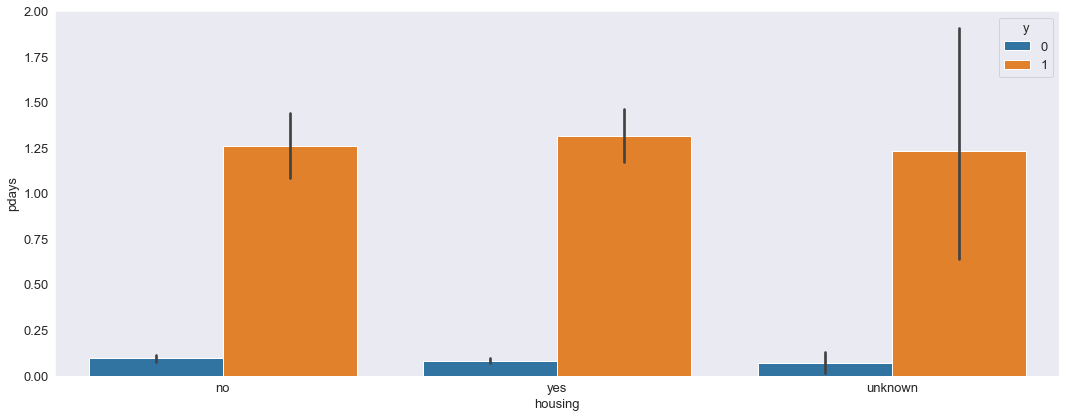

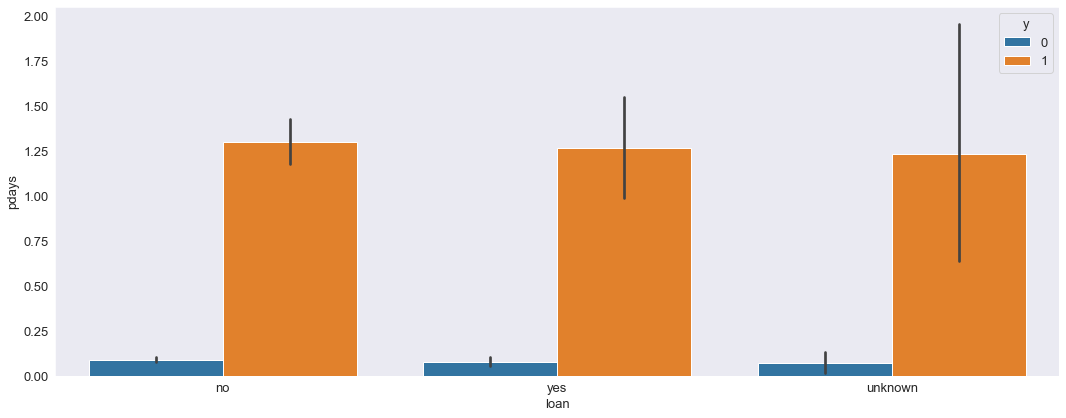

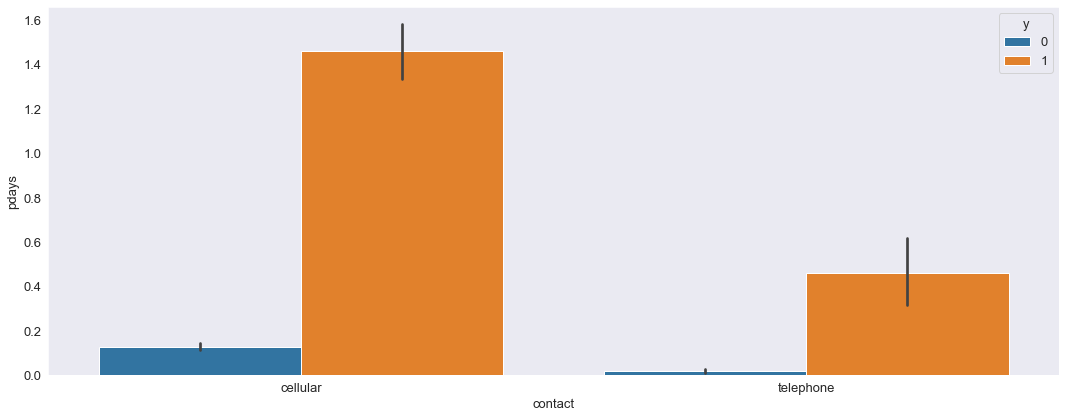

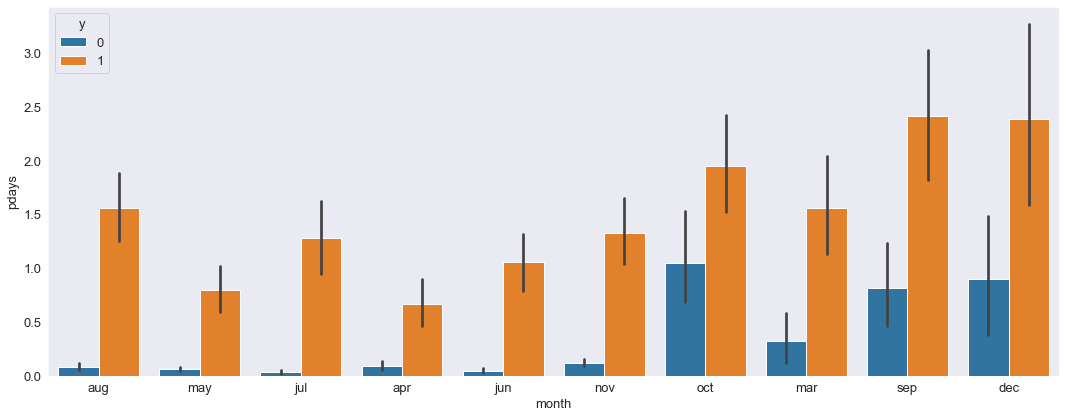

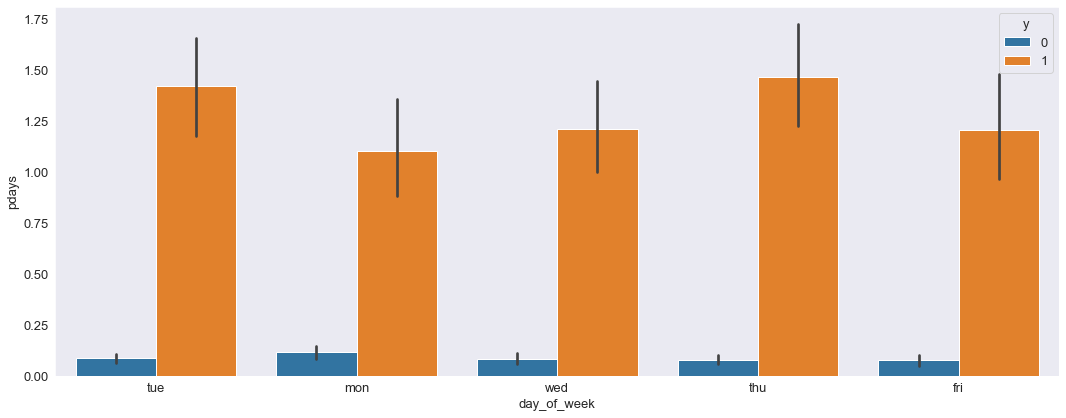

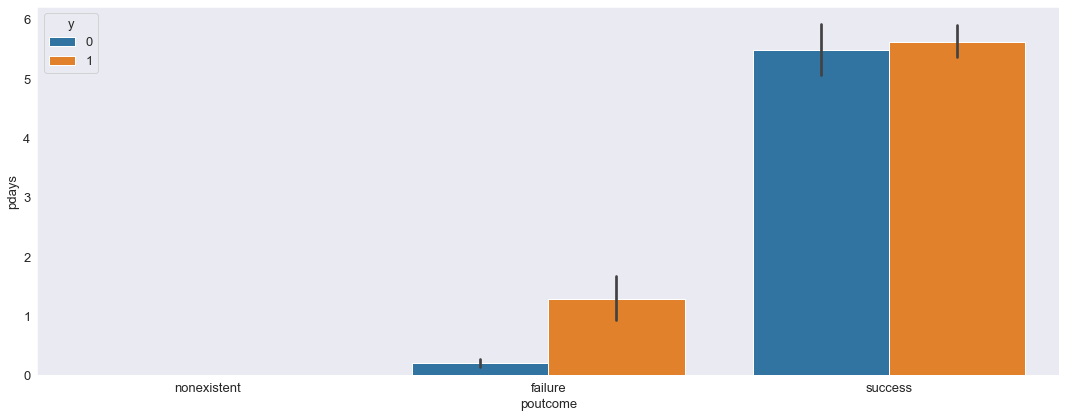

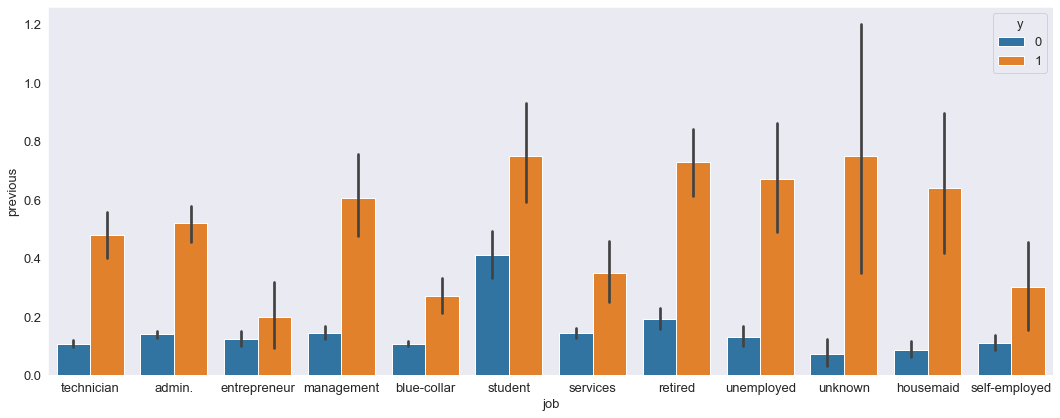

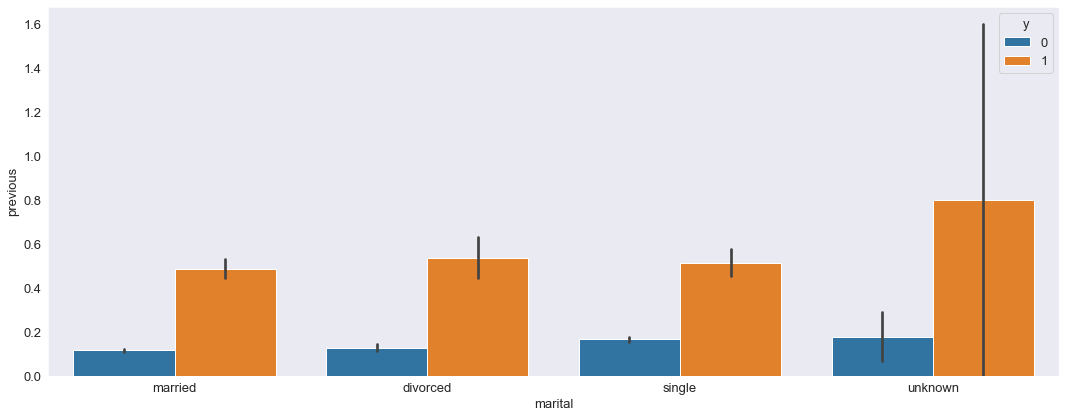

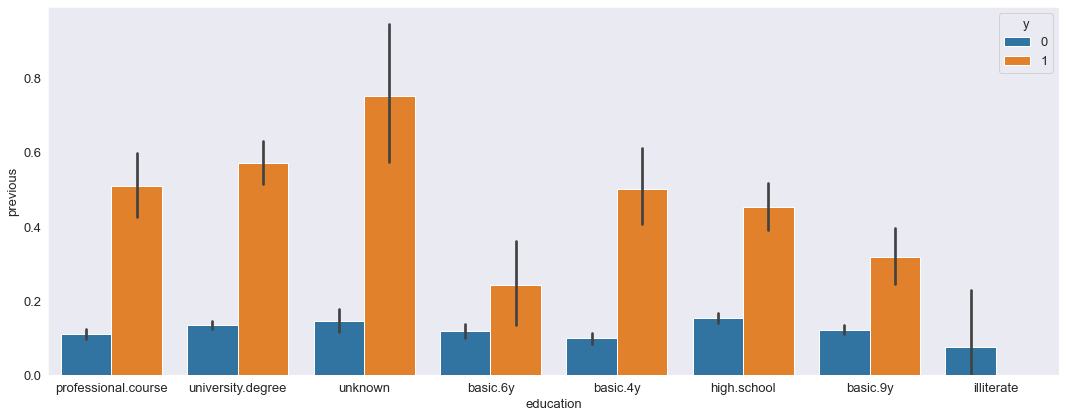

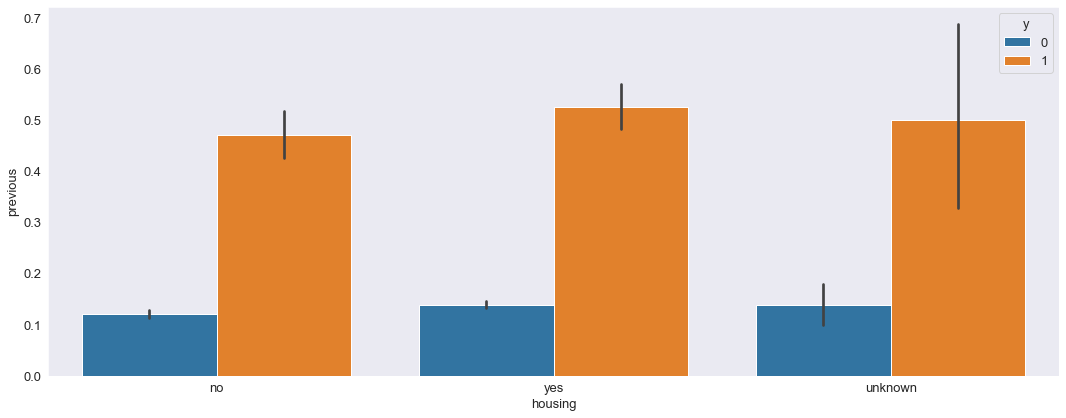

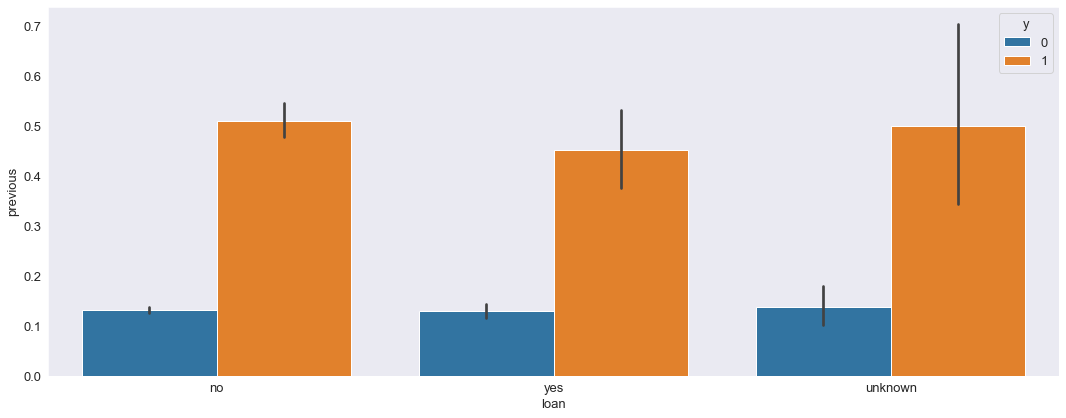

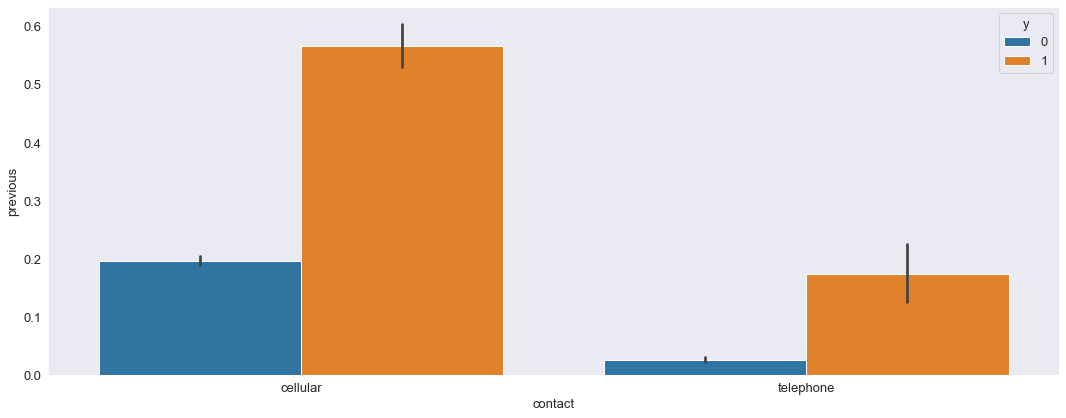

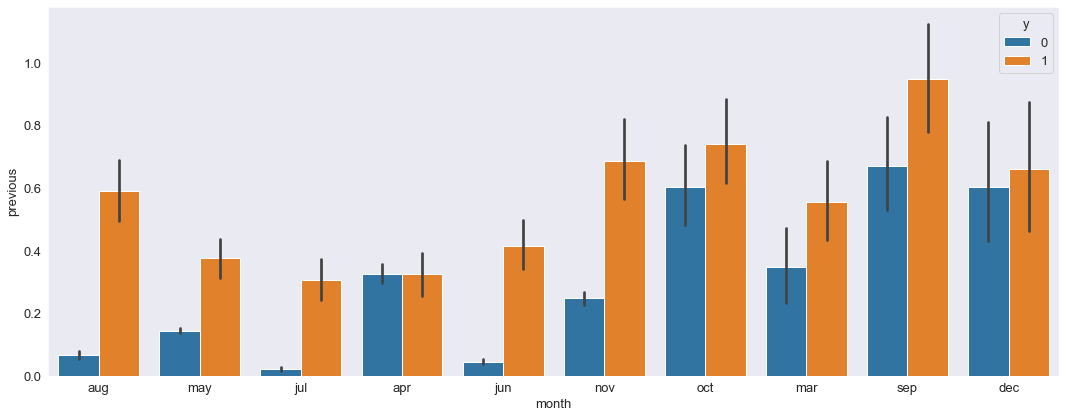

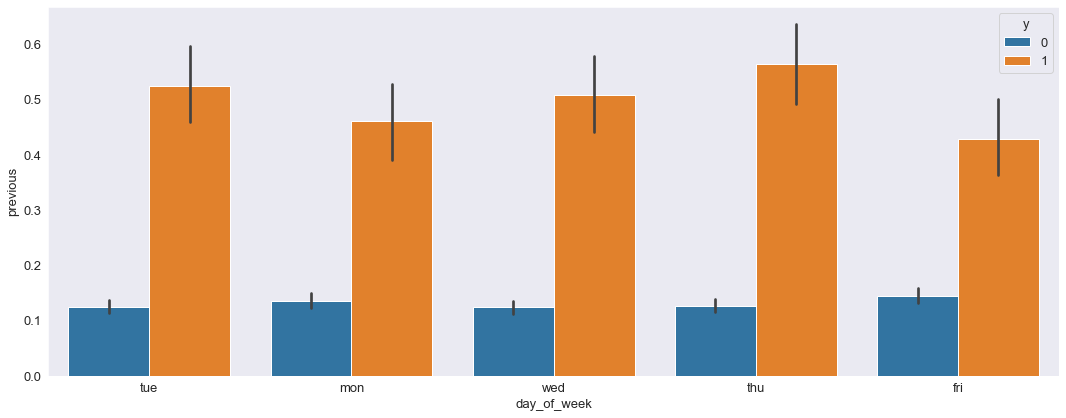

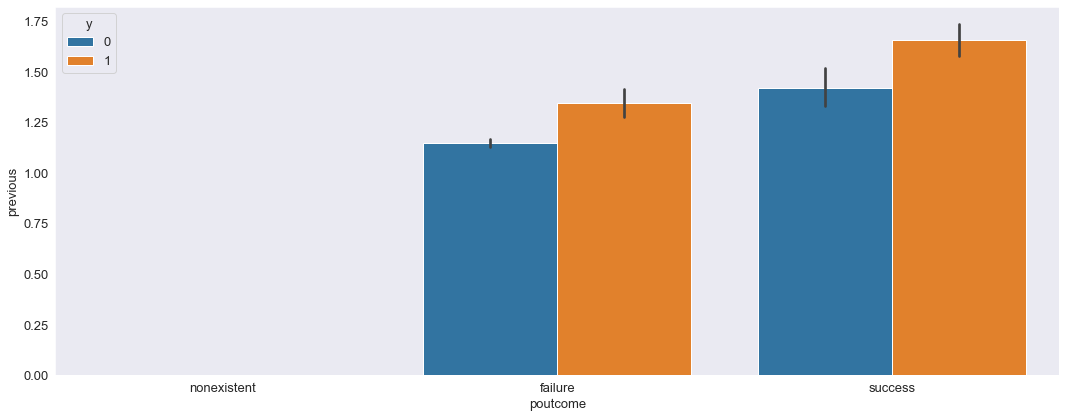

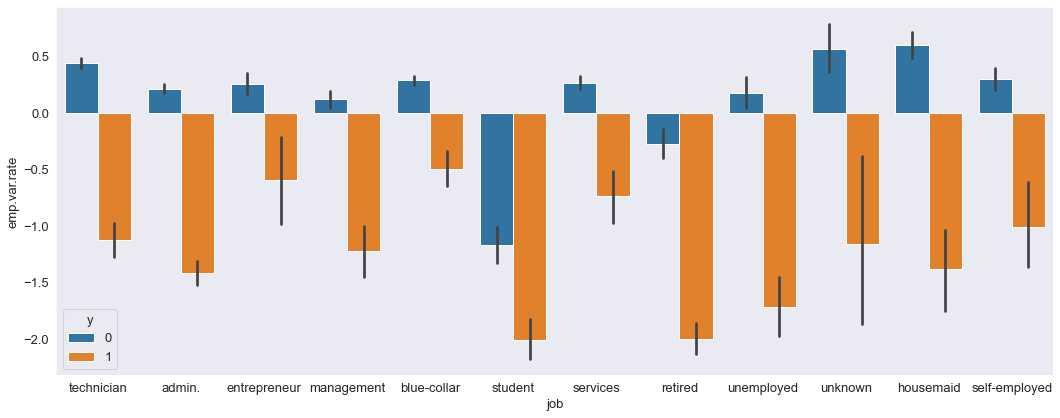

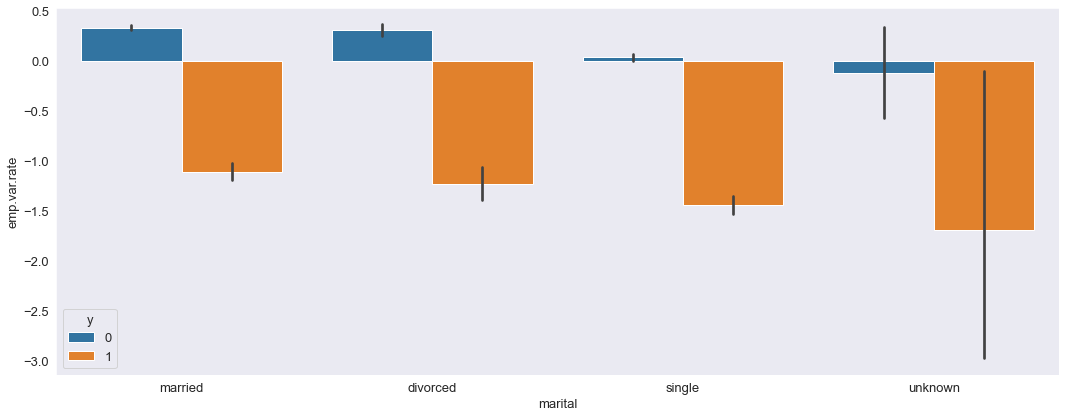

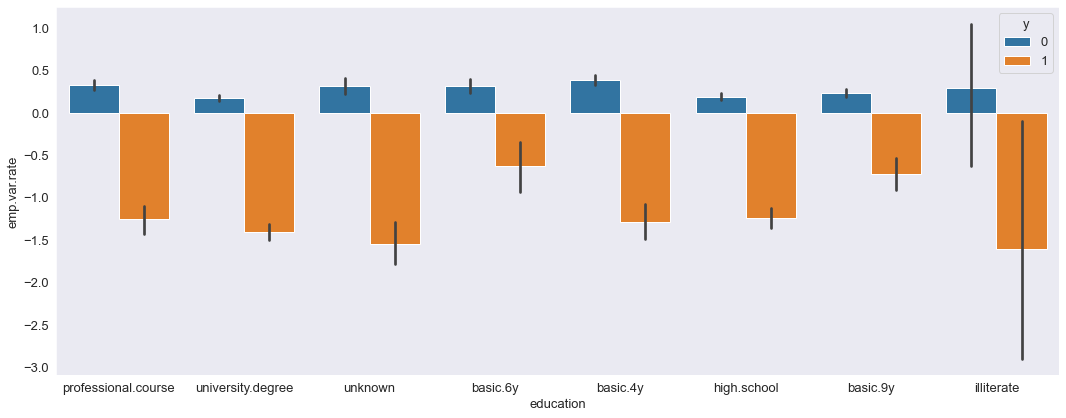

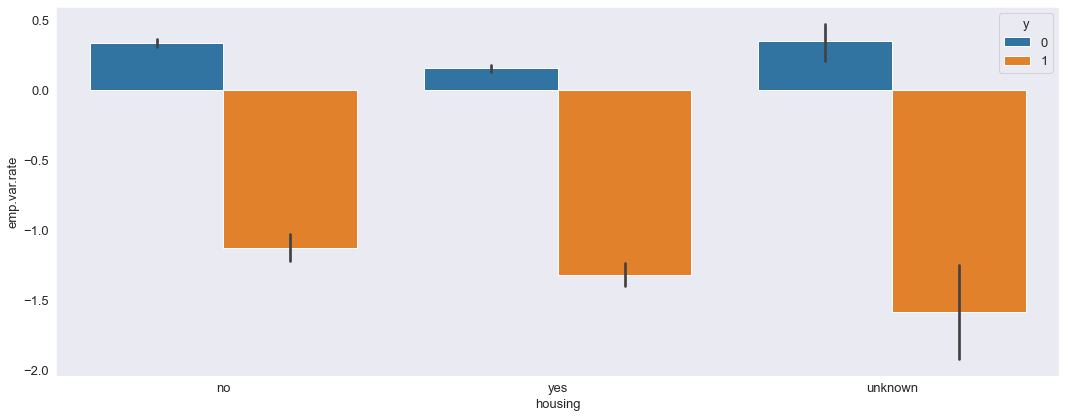

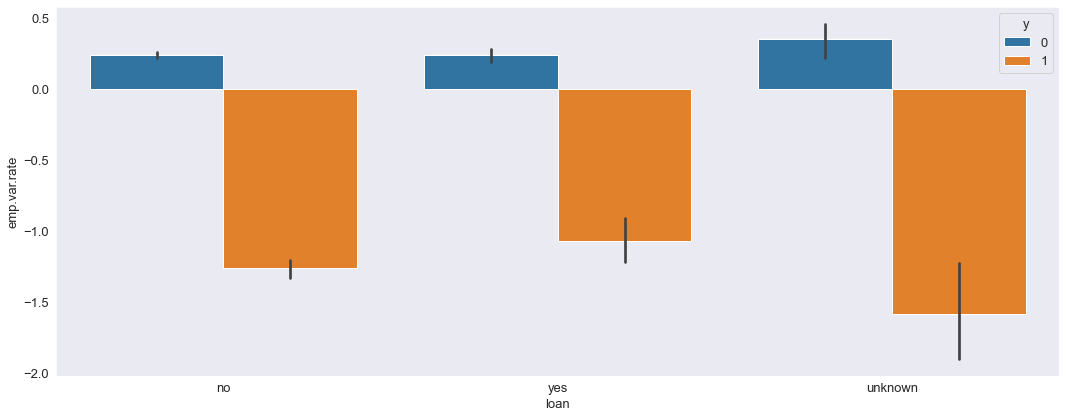

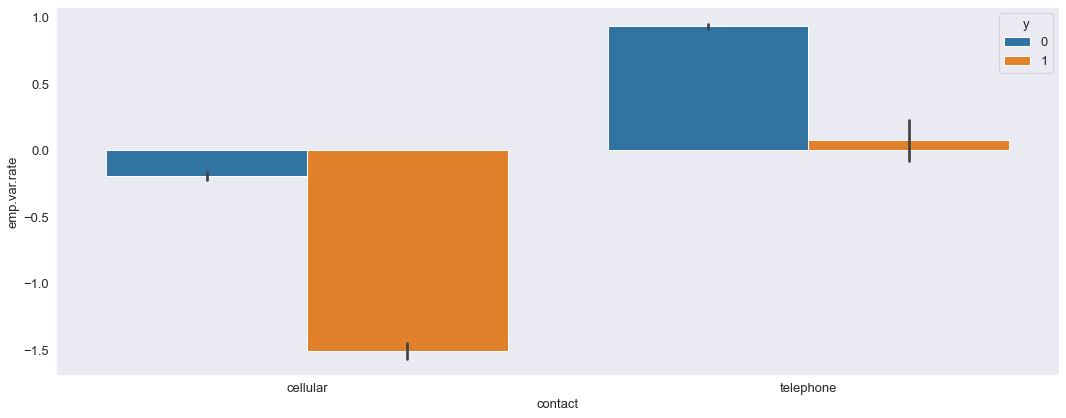

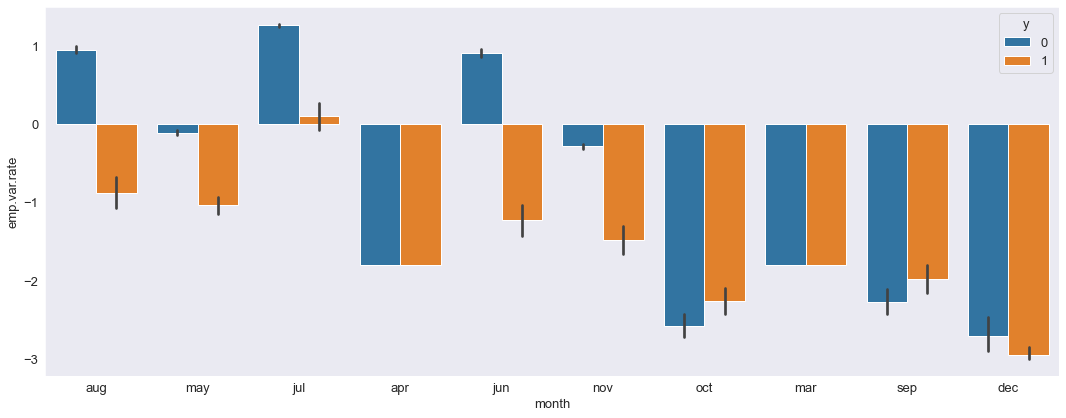

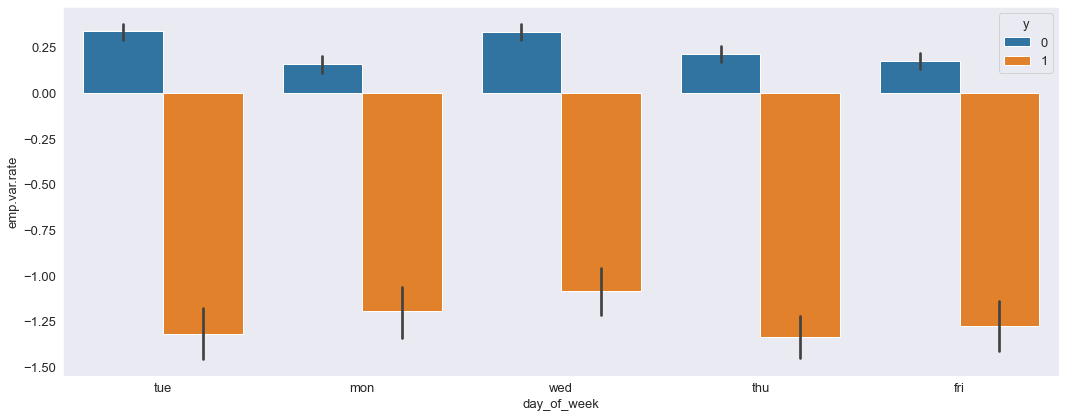

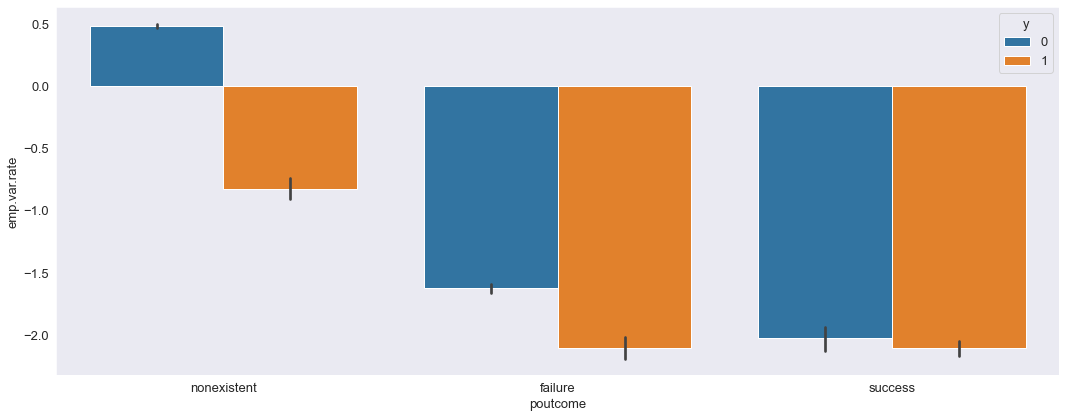

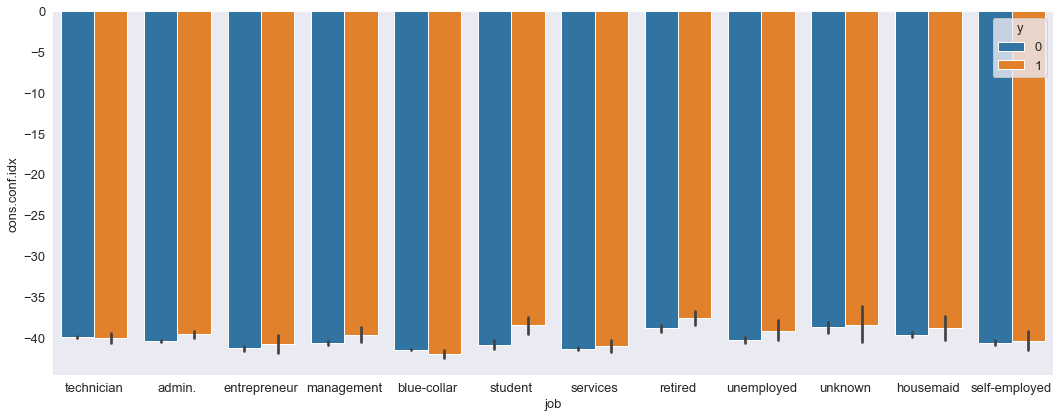

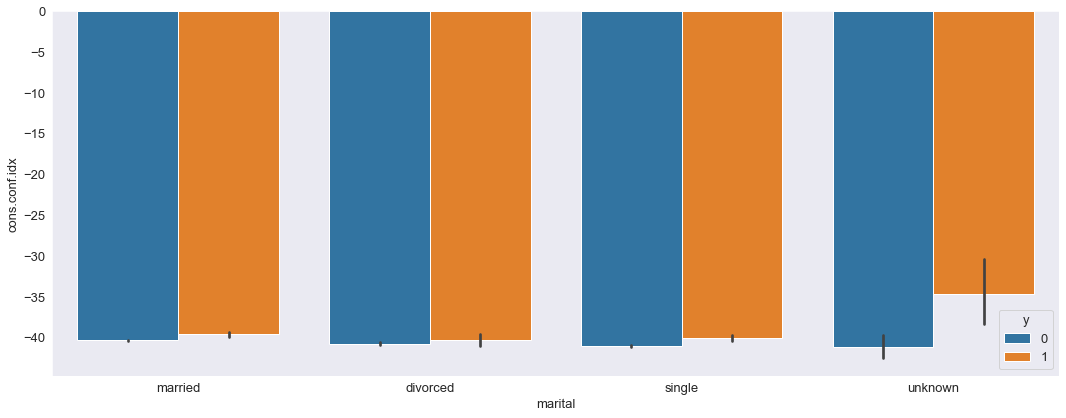

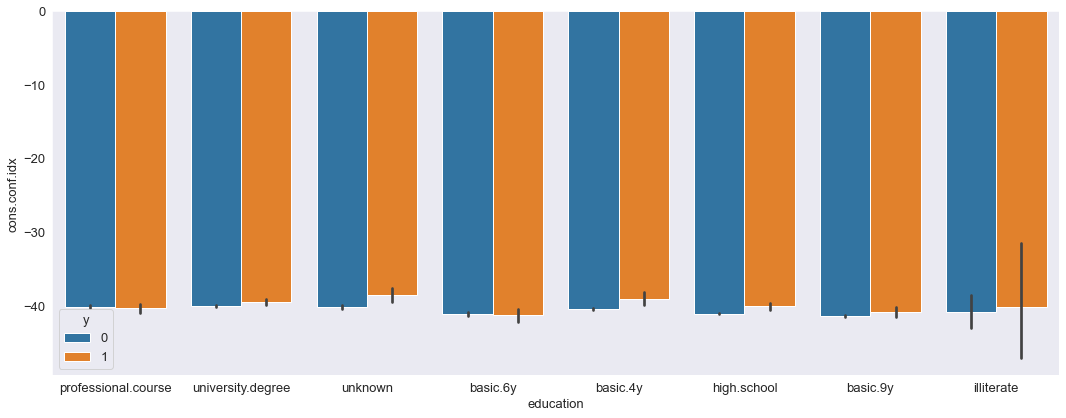

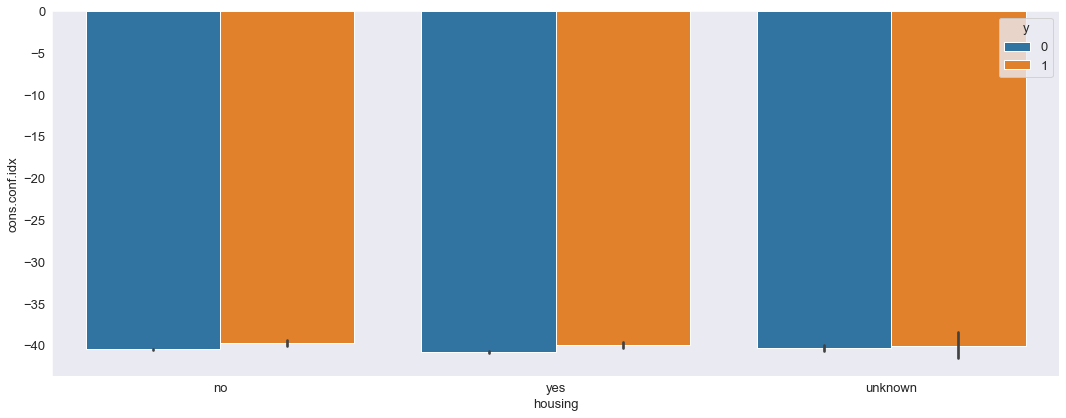

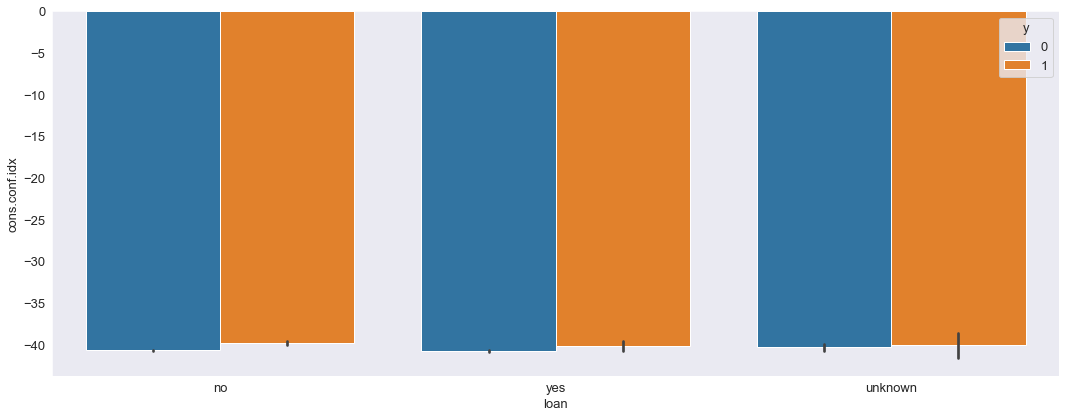

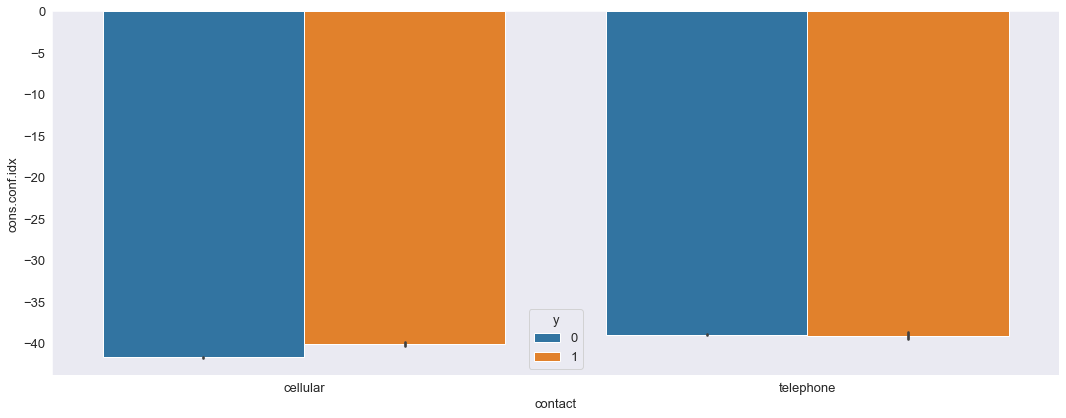

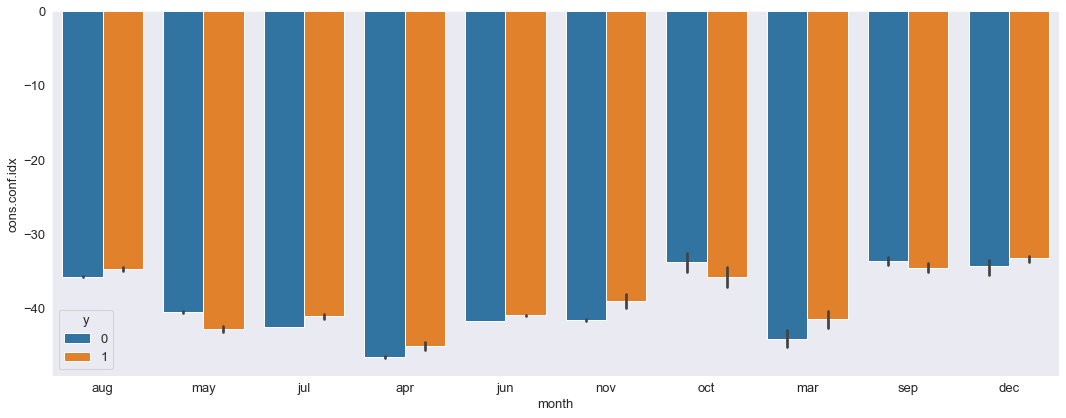

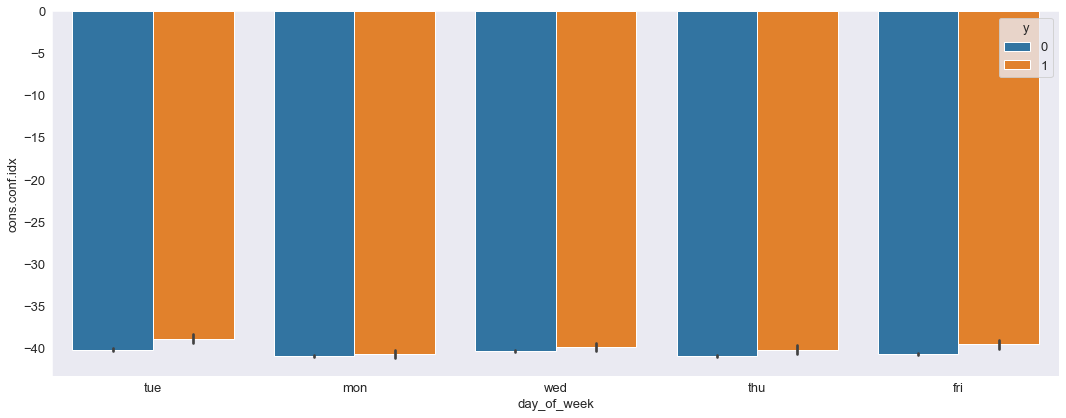

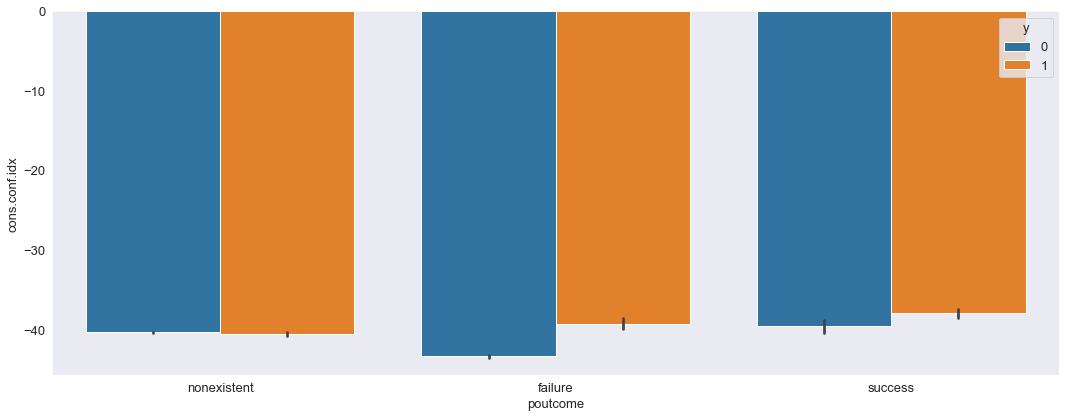

In [28]:
for y in numerical:
    for x in categorical:
        fig,ax = plt.subplots(figsize=(15,6))
        sns.barplot(data=df_train,x=x,y=y,hue='y')
        fig.tight_layout()
        plt.show();

In [29]:
for feature in categorical:
    print('CATEGORICAL: ',feature)
    print('X_train: ',X_train[feature].value_counts().count())
    print('X_valid: ',X_valid[feature].value_counts().count())
    print('X_valid: ',X_test[feature].value_counts().count())
    print('-'*50)

CATEGORICAL:  job
X_train:  12
X_valid:  12
X_valid:  12
--------------------------------------------------
CATEGORICAL:  marital
X_train:  4
X_valid:  4
X_valid:  4
--------------------------------------------------
CATEGORICAL:  education
X_train:  8
X_valid:  8
X_valid:  8
--------------------------------------------------
CATEGORICAL:  housing
X_train:  3
X_valid:  3
X_valid:  3
--------------------------------------------------
CATEGORICAL:  loan
X_train:  3
X_valid:  3
X_valid:  3
--------------------------------------------------
CATEGORICAL:  contact
X_train:  2
X_valid:  2
X_valid:  2
--------------------------------------------------
CATEGORICAL:  month
X_train:  10
X_valid:  10
X_valid:  10
--------------------------------------------------
CATEGORICAL:  day_of_week
X_train:  5
X_valid:  5
X_valid:  5
--------------------------------------------------
CATEGORICAL:  poutcome
X_train:  3
X_valid:  3
X_valid:  3
--------------------------------------------------


# FEATURE ENGINEERING

In [30]:
def Replace_cat(df,feature,value):
    data = df.copy()
    data[feature] = data[feature].replace('unknown',value)
    return data

In [31]:
def Replace_randomsample_categoriacal(df,features):
    data = df.copy()
    for feature in features:
        random_sample = data[data[feature].isin(['yes','no'])].sample(data[data[feature]=='unknown'].shape[0],random_state=0)
        random_sample.index = data[data[feature]=='unknown'].index
        data.loc[data[feature]=='unknown',feature] = random_sample
    return data

In [32]:
def Cardinality(df,categorical):
    high_cardinality = [feature for feature in categorical if df[feature].nunique()>15]
    normal_cardinality = [feature for feature in categorical if df[feature].nunique()>5 and feature not in high_cardinality]
    low_cardinality = [feature for feature in categorical if feature not in high_cardinality+normal_cardinality]
    return high_cardinality,normal_cardinality,low_cardinality

In [33]:
def One_hot_encoding(df,features):
    data = df.copy()
    for feature in features:
        encoder = OneHotEncoder(drop='first')
        encoded_rank = encoder.fit_transform(data[feature].values.reshape(-1,1)).toarray()
        encoded_rank = pd.DataFrame(encoded_rank,columns=feature+'_'+data[feature].value_counts().index.sort_values()[1:])
        data = pd.concat([data,encoded_rank],axis=1)
        data.drop(columns=feature,inplace=True)
    return data

In [34]:
def TOP_encoding(df,features,top):
    data = df.copy()
    for feature in features:
        top_x = [label for label in data[feature].value_counts().head(top).index]
        for label in top_x:
            data[feature+'_'+str(label)] = np.where(data[feature]==label,1,0)
        data.drop(columns=feature,inplace=True)
    return data

# 1. MISSING VALUES
+ job: unknown = house maid
+ education: unknown = university.degree
+ marital: unknown = single
+ housing, loan: random sample

In [35]:
X_train = Replace_cat(X_train,'job','housemaid')
X_train = Replace_cat(X_train,'education','university.degree')
X_train = Replace_cat(X_train,'marital','single')
X_valid = Replace_cat(X_valid,'job','housemaid')
X_valid = Replace_cat(X_valid,'education','university.degree')
X_valid = Replace_cat(X_valid,'marital','single')
X_test = Replace_cat(X_test,'job','housemaid')
X_test = Replace_cat(X_test,'education','university.degree')
X_test = Replace_cat(X_test,'marital','single')

In [36]:
X_train_missing = Replace_randomsample_categoriacal(X_train,['housing','loan'])
X_valid_missing = Replace_randomsample_categoriacal(X_valid,['housing','loan'])
X_test_missing = Replace_randomsample_categoriacal(X_test,['housing','loan'])

# 2. ENCODING
+ High cardinality (>15): 0
+ Normal cardinality (>5): 3 (job,education,month)
+ Low cardinality: (1-5): 6(marital,housing,loan,contact,day_of_week,poutcome)

+ Nomial: job,month,marital,housing,loan,contact,day_of_week,poutcome.
+ Ordinal: education

In [37]:
high_cardinality,normal_cardinality,low_cardinality = Cardinality(X_train,categorical)

In [38]:
high_cardinality

[]

In [39]:
normal_cardinality

['job', 'education', 'month']

In [40]:
low_cardinality

['marital', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']

Nomial

In [41]:
X_train_encoding = One_hot_encoding(X_train_missing,low_cardinality)
X_valid_encoding = One_hot_encoding(X_valid_missing,low_cardinality)
X_test_encoding = One_hot_encoding(X_test_missing,low_cardinality)

In [42]:
nomial_normal = ['job','month']
X_train_encoding = TOP_encoding(X_train_encoding,nomial_normal,top=5)
X_valid_encoding = TOP_encoding(X_valid_encoding,nomial_normal,top=5)
X_test_encoding = TOP_encoding(X_test_encoding,nomial_normal,top=5)

Ordinal

In [43]:
education = {'illiterate':1,'basic.4y':2,'basic.6y':3,'basic.9y':4,'high.school':5,'professional.course':6,'university.degree':7}

In [44]:
X_train_encoding['education'] = X_train_encoding['education'].map(education)
X_valid_encoding['education'] = X_valid_encoding['education'].map(education)
X_test_encoding['education'] = X_test_encoding['education'].map(education)

# 3. IMBALANCED

In [45]:
def Imbalanced(X,y,ratio,method):
    if method == 'undersampling':
        X_balanced,y_balanced = NearMiss(ratio).fit_resample(X,y)
    elif method == 'oversampling':
        X_balanced,y_balanced = RandomOverSampler(ratio).fit_resample(X,y)
    else:
        X_balanced,y_balanced = SMOTETomek(ratio).fit_resample(X,y)
    return X_balanced,y_balanced

In [46]:
X_train,y_train = Imbalanced(X_train_encoding,y_train,1,'SMOTETomek')

In [47]:
X_valid = X_valid_encoding
X_test = X_test_encoding

# MODEL BUILDING

In [48]:
pipeline_NB = Pipeline([('NB_classifier',GaussianNB())])
pipeline_DT = Pipeline([('DT_classifier',DecisionTreeClassifier())])
pipeline_RF =Pipeline([('RF_classifier',RandomForestClassifier())])
pipeline_KNN = Pipeline([('KNN_classifier',KNeighborsClassifier())])
pipeline_GB = Pipeline([('GB_classifier',GradientBoostingClassifier())])
pipeline_XB = Pipeline([('XB_classifier',XGBClassifier())])
pipeline_LG = Pipeline([('LG_classifier',LGBMClassifier())])

In [49]:
pipelines = [pipeline_NB, pipeline_DT, pipeline_RF, pipeline_KNN, pipeline_GB, pipeline_XB, pipeline_LG]

In [50]:
pipe_dict = {0:'Naive Bayes',1: 'Decision Tree', 2:'RandomForest',3:'KNeighbors',4:'Gradient Boosting',5:'XgBoost',6:'LightGBM'}
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [51]:
for i,model in enumerate(pipelines):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    train_accuracy = accuracy_score(y_train,y_train_pred)
    train_f1 = f1_score(y_train,y_train_pred)
    train_precision = precision_score(y_train,y_train_pred)
    train_recall = recall_score(y_train,y_train_pred)
    train_roc_auc_score = roc_auc_score(y_train,y_train_pred)
    
    valid_accuracy = accuracy_score(y_valid,y_valid_pred)
    valid_f1 = f1_score(y_valid,y_valid_pred)
    valid_precision = precision_score(y_valid,y_valid_pred)
    valid_recall = recall_score(y_valid,y_valid_pred)
    valid_roc_auc_score = roc_auc_score(y_valid,y_valid_pred)
    
    print(pipe_dict[i])
    print('Model performance for Training set')
    print('- Accuracy: {:.4f}'.format(train_accuracy))
    print('- F1 score: {:.4f}'.format(train_f1))
    print('- Precision: {:.4f}'.format(train_precision))
    print('- Recall: {:.4f}'.format(train_recall))
    print('- Roc Auc Score: {:.4f}'.format(train_roc_auc_score))
    print('-'*50) 
    print('Model performance for Valid set')
    print('- Accuracy: {:.4f}'.format(valid_accuracy))
    print('- F1 score: {:.4f}'.format(valid_f1))
    print('- Precision: {:.4f}'.format(valid_precision))
    print('- Recall: {:.4f}'.format(valid_recall))
    print('- Roc Auc Score: {:.4f}'.format(valid_roc_auc_score))
    print('-'*50)
    print('Confusion Matrix:','\n',confusion_matrix(y_valid,y_valid_pred))
    print(classification_report(y_valid_pred,y_valid))
    print('='*60)
    print('\n')

Naive Bayes
Model performance for Training set
- Accuracy: 0.8735
- F1 score: 0.8678
- Precision: 0.9088
- Recall: 0.8303
- Roc Auc Score: 0.8735
--------------------------------------------------
Model performance for Valid set
- Accuracy: 0.8686
- F1 score: 0.4405
- Precision: 0.4185
- Recall: 0.4651
- Roc Auc Score: 0.6921
--------------------------------------------------
Confusion Matrix: 
 [[6729  592]
 [ 490  426]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7219
           1       0.47      0.42      0.44      1018

    accuracy                           0.87      8237
   macro avg       0.69      0.68      0.68      8237
weighted avg       0.86      0.87      0.87      8237



Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
--------------------------------------------------
Model performance for Valid set
- Accuracy: 0.

# MACHINE LEARNING

In [52]:
def Evaluate_Classifier(model,X_test,y_test):
    y_pred = model.predict(X_test)
    plot_confusion_matrix(model,X_test,y_test,display_labels=['NO','YES'],cmap=plt.cm.Blues)
    accuracy = accuracy_score(y_test,y_pred)
    print('Model Performance')
    print('Accuracy: {:.0%}'.format(accuracy))
    print(classification_report(y_pred,y_test))
    return accuracy

In [53]:
def Accuracy(model,X,y,name_accuracy):
    print('{}: {score:.2%}'.format(name_accuracy,score = model.score(X,y)))

In [54]:
boosting_type = ['gbdt','dart','goss','rf']
colsample_bytree = [0.3,0.4,0.5,0.7]
learning_rate = [0.05,0.10,0.15,0.20,0.25,0.30]
max_depth = [3,4,5,6,8,10,12,15]
min_child_weight = [1,3,5,7]
n_estimators = [100,150,200,250,500,1000]
num_leaves = 2*max_depth
min_data_in_leaf = [100,200,300,500,1000]
colsample_bytree = [0.3,0.4,0.5,0.7]
early_stopping_round = [1,2,3,4]
lightgbm_params = {
    'boosting_type':boosting_type,
    'colsample_bytree':colsample_bytree,
    'learning_rate':learning_rate,
    'max_depth':max_depth,
    'min_child_weight':min_child_weight,
    'n_estimators':n_estimators,
    'num_leaves':num_leaves,
    'min_data_in_leaf':min_data_in_leaf,
    'colsample_bytree':colsample_bytree,
    'early_stopping_round':early_stopping_round
}

In [55]:
base_model = LGBMClassifier()
base_model.fit(X_train,y_train)

LGBMClassifier()

In [56]:
def Hypertuning_rscv(model,params,n_iter,cv,X_train,y_train):
    random = RandomizedSearchCV(estimator=model, param_distributions=params, n_jobs=-1, n_iter=n_iter, cv=cv,verbose=2, random_state=42)
    random.fit(X_train,y_train)
    best_params = random.best_params_
    best_score = random.best_score_
    best_estimator = random.best_estimator_
    return best_params,best_score,best_estimator

In [57]:
best_params, best_score, best_estimator_random = Hypertuning_rscv(LGBMClassifier(),lightgbm_params,20,10,X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


# Evaluation

In [58]:
Accuracy(base_model,X_train,y_train,'Train Accuracy Base Model')
Accuracy(base_model,X_valid,y_valid,'Valid Accuracy Base Model')
print('')
Accuracy(best_estimator_random,X_train,y_train,'Train Accuracy Randomimzed')
Accuracy(best_estimator_random,X_valid,y_valid,'Valid Accuracy Randomized')

Train Accuracy Base Model: 96.42%
Valid Accuracy Base Model: 91.08%

Train Accuracy Randomimzed: 95.85%
Valid Accuracy Randomized: 91.40%


Model Performance
Accuracy: 91%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7406
           1       0.55      0.61      0.58       831

    accuracy                           0.91      8237
   macro avg       0.75      0.78      0.76      8237
weighted avg       0.91      0.91      0.91      8237



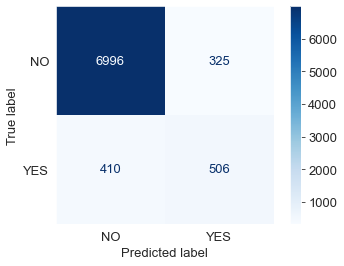

In [59]:
base_accuracy = Evaluate_Classifier(base_model,X_valid,y_valid)

Model Performance
Accuracy: 91%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7469
           1       0.53      0.64      0.58       768

    accuracy                           0.91      8237
   macro avg       0.75      0.79      0.77      8237
weighted avg       0.92      0.91      0.92      8237



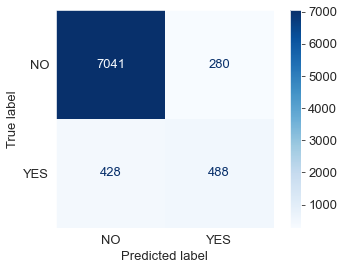

In [60]:
random_accuracy_classifier = Evaluate_Classifier(best_estimator_random,X_valid,y_valid)

In [61]:
print('Improvement of {:.2%}'.format((random_accuracy_classifier-base_accuracy)/base_accuracy))

Improvement of 0.36%


# TEST

Model Performance
Accuracy: 91%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7458
           1       0.53      0.63      0.58       779

    accuracy                           0.91      8237
   macro avg       0.75      0.79      0.76      8237
weighted avg       0.92      0.91      0.92      8237



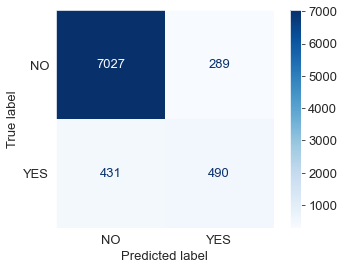

In [62]:
test_accuracy = Evaluate_Classifier(best_estimator_random,X_test,y_test)

+ In all cases of participating in term deposits, the model correctly predicted 53% of cases of time deposit transactions.
+ In all cases actually participating in term deposits the correct prediction model is 63%
+ Accuracy: 91%
+ F1-score: 58%

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


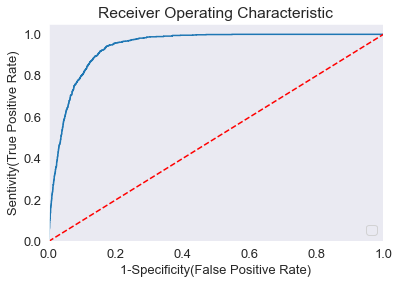

In [63]:
fpr,tpr,thresholds = roc_curve(y_test,best_estimator_random.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sentivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right');